# 0943063 Final Project - Compressing Data sets For machine Learning
https://github.com/nyutal/049063-Information-in-Storage-Devices-Final-Project

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle code cells On/Off"></form>''')

## Introduction
Those days AI & Machine learning hype combined with the information gathered from millions/billions of IoT devices and cellular phones requires passing huge amount of data between endpoints, compression such data is necessity from higher priority.  

In this project we explore several lossless compression methods on different mobile/IoT data sets. We starts from basic well known lossless methods and them apply more sophisticated methods.  
The final part discuss a novel idea (as far as we found) of Huffman variation which includes clustering of multiple Huffman representation.  

We took a decision to put most of our effort to analyze our Clustered Huffman method and its implication, even we know it will come over going deeper in other directions, some examples of such enhancements we didn't explore are Huffman with two characters symbols and LZ78.

Another important decision we took was to implement all the compression algorithm we use for this work from scratch, that from several reasons: first we want to "feel the pain" and understand the nuts and bolts of it, second we wanted to be confidence that the algorithms we run doing what they suppose to do, last and most important we wanted the flexibility to hack and play with the algorithms as our desire for investigation and fine tuning, for example the very easy way to manipulate the LZ compression parameters and achieved best results.  
We implemented all of our work with python and a lot of packages that can be installed manually but can be used easily by install Anaconda distribution. Also, all of our document and most of our code written using jupyter notebook (include this chapter) which made our document writing process to integrate with the development process and far moer easy. jupyter also arrived with Anaconda.

We choose 3 different data set collected by mobile or IT devices that each one have its unique foramt and information sources in order to see the effectiveness of the algorithms on various data set:  
1. runOrWalk: A dataset containing labeled sensor data from accelerometer and gyroscope 
2. mobileLocationHistory102014: History of Locations of an android mobile in the month of October 2014.
3. nyc2016: 'real-time' traffic information from sensor feeds within the five boroughs of NYC.


The rest of our work structured as follow:
* Algorithm implementation discussed our initial implementations (which will we extend later)
* Data set re-formating & Huffman coding and its analysis
* LZ compression and its analysis
* Structured Compression:
    * Using both algorithms together (like GZIP and DEFLATE).
    * LZ77 improvement implementation that split data,control,offset_high,offset_low,direction to different channels.
    * Compression per column.
* Clustered Huffman:
    * Motivation
    * Naive Methods
    * Algorithm
    * Trade-offs 
    * Experiments


## Algorithm Implementation
In this part we will show implementation of the Huffman and LZ77 algorithms required for the task
### Huffman
Our implementation is straight forward, count frequencies, build prefix tree and translate to code. 
It includes a very simple encoded dictionary where for each entry we transmit character, number of code bits and the the code itself. We know there are better ways to transmit a dictionary such "canonical Huffman code" but we decided to focus on other aspects due schedule limitations.

In [1]:
from collections import Counter
import pandas as pd
import heapq

class Huffman(object):
    
    CODE_LENGTH_BITS = 8
    HEADER = ['uncompressed[b]', 'compressed(without code)[b]', 'dictionary[b]', 'neto ratio[b]', 'total ratio[b]']
    
    def __init__(self, stop_chars = []):
        self.stop_chars = stop_chars
        pass
    
    def generate_code(self, char_stream):
        '''
        build huffman code for given char_stream.
        it is initial step in order to compress/decompresse with this class
        '''
        #construct an heap
        counts = dict(Counter(char_stream))
        self.generate_code_from_freq_dict(counts)
        
    
    def generate_code_from_freq_dict(self, counts):
        for c in self.stop_chars:
            if c in counts:
                del counts[c]
        heap = []
        for char, freq in counts.items():
            node = {'val': char, 'left': None, 'right': None}
            heapq.heappush(heap, (freq, node))
            
        self.counts = counts

        #build a prefix tree
        root = self._build_tree(heap)
        
        #produce code
        self.code_dict = {}
        self._traverse_and_code(root, '', self.code_dict)
        
        #convert dict for decode performance
        self.decode_dict = {v:k for k,v in self.code_dict.iteritems()}
    
    def _build_tree(self, heap):
        while len(heap) > 1:
            fr1, right = heapq.heappop(heap)
            fr2, left = heapq.heappop(heap)
            node = { 'left': left, 'right': right}
            heapq.heappush(heap, (fr1 + fr2, node))
        _, root = heapq.heappop(heap)
        return root
    
    def _traverse_and_code(self, node, prefix, code_dict):
        if 'val' in node:
            code_dict[node['val']] = prefix
        else:
            self._traverse_and_code(node['left'], (prefix + '0'), code_dict)
            self._traverse_and_code(node['right'], prefix + '1', code_dict)
    
    def get_code(self):
        return self.code_dict
    
    def set_code(self, d):
        self.code_dict = d
    
    def print_code(self):
        print 'Huffman code:'
        for k, v in self.code_dict.items():
            print '%s %s %s' %(k, ord(k),v)
    
    def pprint_code(self):
        header = ['charactter', 'ascii', 'code']
        table = []
        for k, v in self.code_dict.items():
            table.append([k, ord(k), v])
        print_table(header, table)
        
    
    def get_char_count(self):
        return self.counts
    
    def get_char_freq(self):
        total_counts = float(sum([count for count in self.counts.values()]))
        freq_dict = {k: v / total_counts  for k, v in self.counts.items()}
        return freq_dict
    
    def encode(self, char_stream):
        '''
        return: string represent compressed char_stream bits
        '''
        binary_stream = ''
        for c in char_stream:
            if c not in self.code_dict:
                if c in self.stop_chars:
                    continue
                raise ValueError('%s (ord=%s) not in code_dict' % (c, ord(c)))
            binary_stream += self.code_dict[c]
        return binary_stream
    
    def decode(self, binary_stream):
        '''
        return char string represent uncompresed binary_stream for it's code_dict
        '''
        curr_exp = ''
        char_stream = ''
        
        for b in binary_stream:
            curr_exp += b
            if curr_exp in self.decode_dict:
                char_stream += self.decode_dict[curr_exp]
                curr_exp = ''
        
        if len(curr_exp) != 0:
            raise ValueError('wrong code!!!')
        
        return char_stream
    
    def get_dict_size(self):
        total_len = 0
        for k, v in self.code_dict.items():
            total_len += 8*len(k) + self.CODE_LENGTH_BITS + len(v)
        return total_len
    
    def compression_info(self, char_stream):
        bin_stream = self.encode(char_stream)
        uncompressed_len = 0
        for c in char_stream:
            if c not in self.stop_chars:
                uncompressed_len += 8
        compressed_len = len(bin_stream)
        return uncompressed_len, compressed_len, self.get_dict_size()
    
    def print_compression_info(self, char_stream):
        uncompressed_len, compressed_len, dict_size = self.compression_info(char_stream)
        ratio  = (dict_size + compressed_len) * 1. / uncompressed_len
        table = [[uncompressed_len, compressed_len, dict_size, compressed_len * 1. / uncompressed_len, ratio]]
        print_table(self.HEADER, table)
        return uncompressed_len, compressed_len, dict_size
    
    def compression_info_file(self, fname):
        bin_stream = self.encode(itertools.chain.from_iterable(open(fname)))
        
        uncompressed_len = 0
        for c in itertools.chain.from_iterable(open(fname)):
            if c not in self.stop_chars:
                uncompressed_len += 8
        
        compressed_len = len(bin_stream)

        return uncompressed_len, compressed_len, self.get_dict_size()
        
    def print_compression_info_file(self, fname):
        uncompressed_len, compressed_len, dict_size = self.compression_info_file(fname)
        ratio  = (self.get_dict_size() + compressed_len) * 1. / uncompressed_len
        table = [[uncompressed_len, compressed_len, dict_size, compressed_len * 1. / uncompressed_len, ratio]]
        df = pd.DataFrame(table, columns=self.HEADER)
        pd.options.display.max_columns = None
        display(df)
        return uncompressed_len, compressed_len, dict_size


### LZ77  
The algorithms achieve compression by replacing repeated occurrences of data with references to a single copy of that data existing earlier in the uncompressed data stream. We use the code form HW2 and improve it to support large data and different window size (In part 3 - we will extend this code to support other improvements) ,  
in our LZ77 we can control:
* The minimum sequence for start to copy .
* Maximum of sequence to copy (unsigned int that the 0 =min_seq ,1=min_seq+1) 
* Maximum window size for distance (offset).

In [2]:
import math

class LZ77(object):
    def __init__(self, min_sequence, sequence_length_bits, window_size_bits):
        # type: (object, object) -> object
        self.min_sequence =min_sequence;
        self.sequence_length_bits = sequence_length_bits
        self.max_sequence = pow(2, sequence_length_bits)+self.min_sequence-1
        self.window_size_bits = int(window_size_bits)
        self.window_size = pow(2, window_size_bits)-1
        self.length_format = '{:0%sb}' % sequence_length_bits
        self.offset_format = '{:0%sb}' % window_size_bits

    def compress(self, data, debug=None):
        if debug is None:
            debug = False

        compressed_data = ''
        compressed_data_no_literal = ''
        window = ''
        self.literal_num = 0

        i = 0
        while i < len(data):
            seq_len = 1
            while i + seq_len <= len(data) and seq_len <= self.max_sequence and data[i:i + seq_len] in window:
                seq_len += 1

            seq_len -= 1
            if seq_len >= self.min_sequence and data[i:i + seq_len] in window:
                offset = min(i, self.window_size) - window.rfind(data[i:i + seq_len])
                compressed_data += self.writePair(offset, seq_len, debug)
                window += data[i:i + seq_len]
                i += seq_len
            else:
                compressed_data += self.writeLitteral(data[i], debug)
                compressed_data_no_literal += self.writeLitteral(data[i], debug)
                window += data[i]
                i += 1

            window = window[-self.window_size:]
        return compressed_data, compressed_data_no_literal


    def writeLitteral(self, literal, debug):
        res = literal if debug else '0'+bin(ord(literal))[2:].zfill(8)
        #print res
        return res
    def writePair(self, offset,length, debug):
        if debug:
            res = '(' + str(length) + ',' + str(offset) + ')'
        else:
            res = '1' +self.offset_format.format(offset) + self.length_format.format(length)
        self.literal_num += 1
        return res

    #convert number to binary
    def binary(self,num, length=8):
        return format(num, 'b'.format(length+1))

    #convert binary stream to sring
    def decode_binary_string(self,s):
        str=''.join(chr(int(s[i*8:i*8+8],2)) for i in range(len(s)/8))
        return str if (len(s)%8 == 0) else str+(chr(int(s[-(len(s)%8):],2)))


### General helper functions
We implemented several helper functions which aren't tightly relate to the core compression algorithms but needed for our analysis process.
file to stream converter, table printer, count frequency plotter, sizes converter etc.

In [11]:
import itertools
import seaborn as sns
import pandas as pd
from IPython.display import display

%matplotlib inline

def get_file_char_stream(fname):
    '''
    ret: in order to read large files, this method returns char based iterable
    
    reads file line by line, so doesn't help in case of one big line file.
    can't pass stream more than once.
    '''
    return itertools.chain.from_iterable(open(fname))

def get_json_key_count(obj, kdict):
    '''
    return dictionary contains json keys count.
    will be used as helper to re-format data sets.
    '''
    if isinstance(obj, dict):
        for k, item in obj.items():
            kdict[k] = kdict.get(k, 0) + 1
            get_json_key_count(item, kdict)
    elif any(isinstance(obj, t) for t in (list, tuple)):
        for item in obj:
            get_json_key_count(item, kdict)

def print_table(header, table):
    df = pd.DataFrame(table, columns=header)
    pd.options.display.max_columns = None
    display(df)    

def count_plot_from_dict(dictionary, x_, y_, title):
#     dictionary = dict(h.get_char_freq())
    df = pd.DataFrame(dictionary.items(), columns=[x_, y_])
    ax = sns.barplot(x=x_, y=y_, data=df)
    ax.set_title(title)
    
    
###################################
#return data size in kB
###################################
def size_KB(x):
    return round(x / 8192.0, 2)
###################################
#convert csv/dat file to srting
###################################
def conv_file2str(f):
    str=''
    with open(f) as fp:
        for line in fp:
          str+=line
    return str

###################################
# create summary plot
#####################################
def plot(data_size_arr,title,labels,figure_i):

    fig = plt.figure(figure_i)
    fig.subplots_adjust(bottom=0.2)
    index = np.arange(len(data_size_arr))
    ax = sns.barplot()
    bar_width = 0.35

    rects = ax.bar(index, data_size_arr, bar_width, label=labels, align='center')
    ax.cla()

    for i in range(len(data_size_arr)):
        ax.bar(index[i], data_size_arr[i], bar_width, label=labels[i], align='center')
    plt.xticks([])
    #ax.set_xticklabels(['Original Data',"huffman- input alphabet1",\
    #                       "huffman- input alphabet2","huffman- input alphabet3"])

    bars_label(rects, ax)
    fig.set_size_inches(12.5, 8.5, forward=True)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)
    plt.ylabel('Size[KB]')
    plt.title(title)
    fig_name=(title.replace(': ','_')).replace(' ','_')
    if not os.path.exists(".\Graphs"):
        os.makedirs(".\..\Graphs")
    plt.savefig("./../Graphs/"+fig_name+'.png')
    compress_ratio=[round(x/data_size_arr[0],2) for x in data_size_arr]
    print "Compression Ratio:",compress_ratio

###################################
#create labe to bars
###################################
def bars_label(rects, ax):
       # Get y-axis height to calculate label position from.
       (y_bottom, y_top) = ax.get_ylim()
       y_height = y_top - y_bottom

       for rect in rects:
           height = rect.get_height()
           label_position = height + (y_height * 0.01)
           ax.text(rect.get_x() + rect.get_width() / 2., label_position,
                   '%d' % int(height),
                   ha='center', va='bottom')



### Directories to import files

In [4]:
import sys
sys.path.append('.')
sys.path.append('.\huffman')
sys.path.append('.\LZ77')
sys.path.append('.\Part3-huffman_and_LZ77\lz77_and_huffman')
sys.path.append('.\Part3-huffman_and_LZ77\lz77_and_huffman_split_data_control')
sys.path.append('.\Part3-huffman_and_LZ77\separate_columns')
import matplotlib.pyplot as plt
plt.rcdefaults()
from External_func import *

## Part 1 - Data sets Reformating & Huffman Code 

## Data set 1  - Run Or Walk
### A dataset containing labeled sensor data from accelerometer and gyroscope 
https://www.kaggle.com/vmalyi/run-or-walk  
  
The data stored in CSV format, sized 7589889 bytes (7.2M) and contains 88589 samples.  
It includes header line with column description:  
date, time, username, wrist id, activity id (run/walk) meta-data and acceleration and gyro sensor data for x,y,z axes each.   

Let's load the data and preview few lines:

In [5]:
RUN_OR_WALK_PATH = '../data_sets/runOrWalk/dataset.csv'

import numpy as np
import pandas as pd
df = pd.read_csv(RUN_OR_WALK_PATH)
df.head()

,date,time,username,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,2017-6-30,13:51:15:847724020,viktor,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,2017-6-30,13:51:16:246945023,viktor,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,2017-6-30,13:51:16:446233987,viktor,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,2017-6-30,13:51:16:646117985,viktor,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,2017-6-30,13:51:16:846738994,viktor,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922


Before starting to analyze compression ratios we will reformat the data:  
1. Although some of the fields contains fixed length values (ex. activity row), we decided to provide the simplest analysis in parts 1/2, hence we will not remove the one char delimiters ',' in those parts.  
2. Remove CSV header line  
3. remove old fashion break line '\r\n' to one character '\n'


In [6]:
import os 

RUN_OR_WALK_REFORMAT_V1_PATH = '../modified_data_sets/runOrWalk/runOrWalk_v1.csv'

if not os.path.isfile(RUN_OR_WALK_REFORMAT_V1_PATH):
    fw = open(RUN_OR_WALK_REFORMAT_V1_PATH,'w')
    with open(RUN_OR_WALK_PATH,'r') as fr:
        fr.readline()
        for l in fr.readlines():
            fw.write(l.replace('\r',''))
    fw.close()


### Run Or Walk Huffman Coding  

Let's construct the Huffman Code, print it's values:

,charactter,ascii,code
0,r,114,101101
1,v,118,001111
2,i,105,0011100
3,k,107,101111
4,\n,10,0011101
5,-,45,0100
6,",",44,100
7,o,111,101110
8,.,46,0010
9,1,49,110


,uncompressed[b],compressed(without code)[b],dictionary[b],neto ratio[b],total ratio[b]
0,60009600,30408118,438,0.506721,0.506728


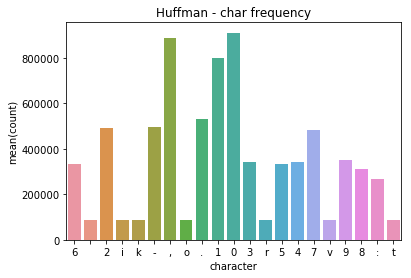

In [12]:
h = Huffman()
h.generate_code(get_file_char_stream(RUN_OR_WALK_REFORMAT_V1_PATH))
h.pprint_code()
count_plot_from_dict(h.get_char_count(), 'character', 'count', 'Huffman - char frequency')
h_1_uc, h_1_c, _ = h.print_compression_info_file(RUN_OR_WALK_REFORMAT_V1_PATH)
h_1_ratio = h_1_c*1. / h_1_uc

Finally, although we know that the Huffman coding is optimal, we can see that messing the dictionary code randomly cause compression to be worth by ~13%

In [13]:
from random import shuffle

code = h.get_code()
keys = code.keys()[:]
values = code.values()[:]
shuffle(values)
h.set_code(dict(zip(keys, values)))
h.pprint_code()
h.print_compression_info_file(RUN_OR_WALK_REFORMAT_V1_PATH)
dummy=1


,charactter,ascii,code
0,6,54,100
1,i,105,0010
2,k,107,00010
3,\n,10,00011
4,-,45,101101
5,",",44,0011100
6,o,111,00000
7,.,46,1110
8,1,49,00001
9,0,48,0101


,uncompressed[b],compressed(without code)[b],dictionary[b],neto ratio[b],total ratio[b]
0,60009600,38003741,438,0.633294,0.633302


## Data set 2 - Mobile location history of 10/2014 
#### History of Locations of an android mobile in the month of October 2014.
https://www.kaggle.com/juliansimon/location-history

The dataset provided in JSON format and isn't tabular, means there are records that contains different numbers of fields and lists. file size is 6149910 bytes (5.9M)

Examples:
1. 
   {                                                                                                                                                                      
     "timestampMs" : "1415045775364",                                                                                                                                        
     "latitudeE7" : 404213246,                                                                                                                                               
     "longitudeE7" : -36285327,                                                                                                                                              
     "accuracy" : 36                                                                                                                                                         
   }
2. {                                                                                                                                                                      
     "timestampMs" : "1415045715276",                                                                                                                                        
     "latitudeE7" : 404213284,                                                                                                                                               
     "longitudeE7" : -36285262,                                                                                                                                              
     "accuracy" : 36,                                                                                                                                                        
     "activitys" : [ {                                                                                                                                                       
       "timestampMs" : "1415045702461",                                                                                                                                      
       "activities" : [ {                                                                                                                                                    
         "type" : "unknown",                                                                                                                                                 
         "confidence" : 68                                                                                                                                                   
       }, {                                                                                                                                                                  
         "type" : "onBicycle",                                                                                                                                               
         "confidence" : 19                                                                                                                                                   
       }, {                                                                                                                                                                  
         "type" : "inVehicle",                                                                                                                                               
         "confidence" : 8                                                                                                                                                    
       }, {                                                                                                                                                                  
         "type" : "still",                                                                                                                                                   
         "confidence" : 6                                                                                                                                                    
       } ]                                                                                                                                                                   
     } ] 
    }

This format provides some hardness in reducing footprint by structure, because it isn't deterministic we can't just drop the key names (and some of the enumerated value names).  
However JSON format contains a lot of non semantic information spaces and line breaks suppose to make the data set easier to read by human beings. 
Before applying any fancy compression we can easily reduce data set size by give up the human readability and trim all the fluffy characters. 
reading the data set and dump it again with python JSON package reduce the file size from 6149910 Bytes to 4865853 Bytes (0.79%), it becoming a one big line looking like that:
....{"latitudeE7": 404212492, "accuracy": 26, "longitudeE7": -36286189, "timestampMs": "1412114163888"}, {"latitudeE7": 404212787, "accuracy": 21, "longitudeE7": -36285734, "timestampMs": "1412114103956"}....

but the default dump still pad spaces after ':' and ',', so we can do better by drop it too (code below) that output data set file sized 4476978 Bytes (0.72%)

In [14]:
MOBILE_LOCATION_HISTORY_PATH = '../data_sets/mobileLocationHistory102014/location_history_102014.json'
MOBILE_LOCATION_HISTORY_REFORMAT_V1_PATH = '../modified_data_sets/mobileLocationHistory102014/location_history_102014_v1.json'

import json
if not os.path.isfile(MOBILE_LOCATION_HISTORY_REFORMAT_V1_PATH):
    with open(MOBILE_LOCATION_HISTORY_PATH, 'r') as fr:
        raw = json.loads(fr.read())
    with open(MOBILE_LOCATION_HISTORY_REFORMAT_V1_PATH, 'w') as outfile:
        json.dump(raw, outfile, separators=(',', ':'))


### Mobile location Huffman Coding
Let's construct the Huffman Code, calculate the compressed size and plot the char count:

,uncompressed[b],compressed(without code)[b],dictionary[b],neto ratio[b],total ratio[b]
0,35815824,21947999,1025,0.612802,0.61283


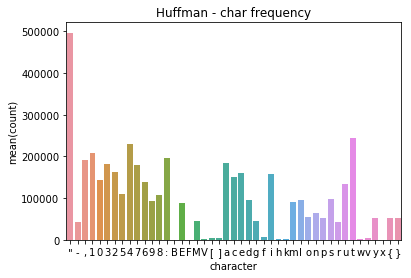

In [15]:
h = Huffman()
h.generate_code(get_file_char_stream(MOBILE_LOCATION_HISTORY_REFORMAT_V1_PATH))
h_2_uc, h_2_c, _ = h.print_compression_info_file(MOBILE_LOCATION_HISTORY_REFORMAT_V1_PATH)
h_2_ratio = h_2_c*1. / h_2_uc
count_plot_from_dict(h.get_char_count(), 'character', 'count', 'Huffman - char frequency')

## Data set 3 - 2016 NYC Real Time Traffic Speed Data Feed  
The data contains 'real-time' traffic information from locations where NYCDOT picks up sensor feeds within the five boroughs of NYC, mostly on major arterials and highways. The data includes some meta fields such id, status, date and link id and the sensored data speed/travel time.

We works on April 2016 data set, which contains 1141384 records in CSV format. Total size is 62972355 [Bytes] (60M).

Let's load the data and see the header and few lines. Also, as done in data set 1, we will remove the header line and '\r' character and in addition will remove a lot of " signs that for some reason wrapped each field value.  
The re-formated file size is 49275703[Bytes] (78% of original)

In [17]:
NYC_PATH = '../data_sets/nyc2016/april2016.csv'
NYC_REFORMAT_V1_PATH = '../modified_data_sets/nyc2016/april2016_v1.csv'

if not os.path.isfile(NYC_REFORMAT_V1_PATH):
    fw = open(NYC_REFORMAT_V1_PATH,'w')
    with open(NYC_PATH,'r') as fr:
        fr.readline()
        for l in fr.readlines():
            fw.write(l.replace('\r','').replace('"',''))
    fw.close()

df = pd.read_csv(NYC_PATH)
df.head()



,Id,Speed,TravelTime,Status,DataAsOf,linkId
0,169,57.17,162,0,4/1/2016 00:05:50,4616355
1,170,55.92,67,0,4/1/2016 00:05:50,4616356
2,171,14.91,807,0,4/1/2016 00:05:50,4616357
3,172,54.06,79,0,4/1/2016 00:05:50,4616310
4,177,54.06,80,0,4/1/2016 00:05:50,4616309


### NYC Huffman Coding  

We will construct the Huffman Code, and calculate the compressed size.
From looking on the char count we can see high frequency of the '"' character. reviewing the data set revealed a lot of reserved quotation marks which turn out wrapped each cell value, hence we re-formated the file before presented Huffman.

,uncompressed[b],compressed(without code)[b],dictionary[b],neto ratio[b],total ratio[b]
0,394205624,191618798,348,0.486088,0.486089


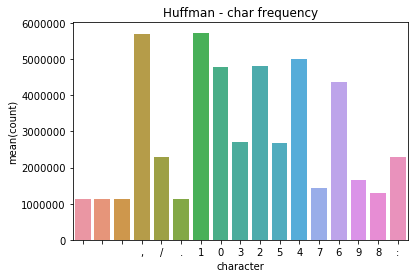

In [19]:
h = Huffman()
h.generate_code(get_file_char_stream(NYC_REFORMAT_V1_PATH))
h_3_uc, h_3_c, _ = h.print_compression_info_file(NYC_REFORMAT_V1_PATH)
h_3_ratio = h_3_c*1. / h_3_uc
count_plot_from_dict(h.get_char_count(), 'character', 'count', 'Huffman - char frequency')

## Part 2 - LZ77 
For the second part we used LZ77 that we implement in HW2:
LZ77- algorithms achieve compression by replacing repeated occurrences of data with references to a single copy of that data existing earlier in the uncompressed data stream. A match is encoded by a pair of numbers called a [length,distance]
In this part we need to decide for each data set how we disguise between the pure literal to the [length,distance] pair.  
We try different approaches using LZ77:
#### 1st method-  
we disguise between the pure character and the [length,distance] pair by adding another bit  to each one of them
For example: we added 1 bit for each character and now character represented by 9 bits (instead of 8).
The new mapping is :  
pure character =**[0,char]** ,length-distance pair= **[1,unsingned 8 bit length,1,unsingned 8 bit length]**
In this method we change the values: the bits number of each symbol is 9
and the minimum for length character to copy (3, 5, 7)

#### 2nd method-   
Like the 1st method we add another bit for each character but instead of using the "naive" mapping,
We change the filed sizes of length-distance pair not to be equal to symbol, but for to values that give maximum results. 
Then new mapping: pure character =**[0,char]** ,[length,distance] pair=**[1,unsigned x bits length, y bit offset]** .
now we can also change the tuple size to be y times as the pure literal size
For conclusion in our algorithm we have 3 degrees of freedom:
1) The bits size of the length.
2) The bits size of the offset.
3) The min length character to copy we choose 3,5,7.  
    
for each data set we check possibilities and we represent the best result we get when we use the training set
##### 3rd method-  
We disguise between the pure character and the **[length,distance]** pair by adding special char before the **[length,distance]** pair
The mapping:  
pure character =**char**, length-distance pair=**[special char, unsigned x bits length, unsigned y bit distance]**
In this case we assume that not all 256 characters exist in the data and we can use one character that not appear for the special char.
In this algorithm we have 3  freedom degrees:  
1) The min length character to copy we choose 3, 5, 7.    
2) The maximum character we can copy (unsigned x bits length).  
3) The maximum distance we can use in our history (unsigned y bit distance).
In this method we save pay more overhead in  **[length,distance]** pair compare to the previous method ,but save bit in each data character.  
**Note:** in our code we implement fast mode and slow mode, the difference is the range of values we choose for each freedom degree.  
For each data we learn the optimize parameters for the lz77 algorithm in slow mode  and use it in the fast mode. 


### Data set 1  - Run Or Walk

In [5]:
### Parmaters for the runOrWalk Data set

data_file=['..\modified_data_sets\\runOrWalk\\runOrWalk_v1.csv']
train_set_file=['..\modified_data_sets\\runOrWalk\\runOrWalk_v1_train_set.dat']
title=['runOrWalk']
debug=True  #Debug mode -choose way data compressed is displayed
Fast_mode =True #Don't try all option of bit separation and symbole size
max_seq_bits=[[5,6]] #for fast mode  decide the range values for max_seq bits(length)
window_size_bits_s=[[17,18]]#for fast mode  decide the range values for window_size bits(offset)
window_size_bits_d=[[18,19]]#for fast mode  decide the range values for window_size bits(offset)

In [ ]:
from lz77_ext_func_bit_separation import LZ77_bit_separate
from lz77_ext_func_delimiter import LZ77_delimiter_separate
from my_LZ77 import LZ77

for i in range(len(data_file)):
    figure_i=2*i
    lz77_bit=LZ77_bit_separate(data_file[i],train_set_file[i],"LZ77 Compression (bit separation): "+title[i],Fast_mode,
                               max_seq_bits[i],window_size_bits_s[i],debug)
    lz77_bit.perform_compression_statistics(figure_i)

    lz77_delim=LZ77_delimiter_separate( data_file[i],train_set_file[i],"LZ77 Compression (delimiter separation): "+title[i],
                                        Fast_mode,max_seq_bits[i], window_size_bits_d[i])
    lz77_delim.perform_compression_statistics(figure_i+1)
plt.show()

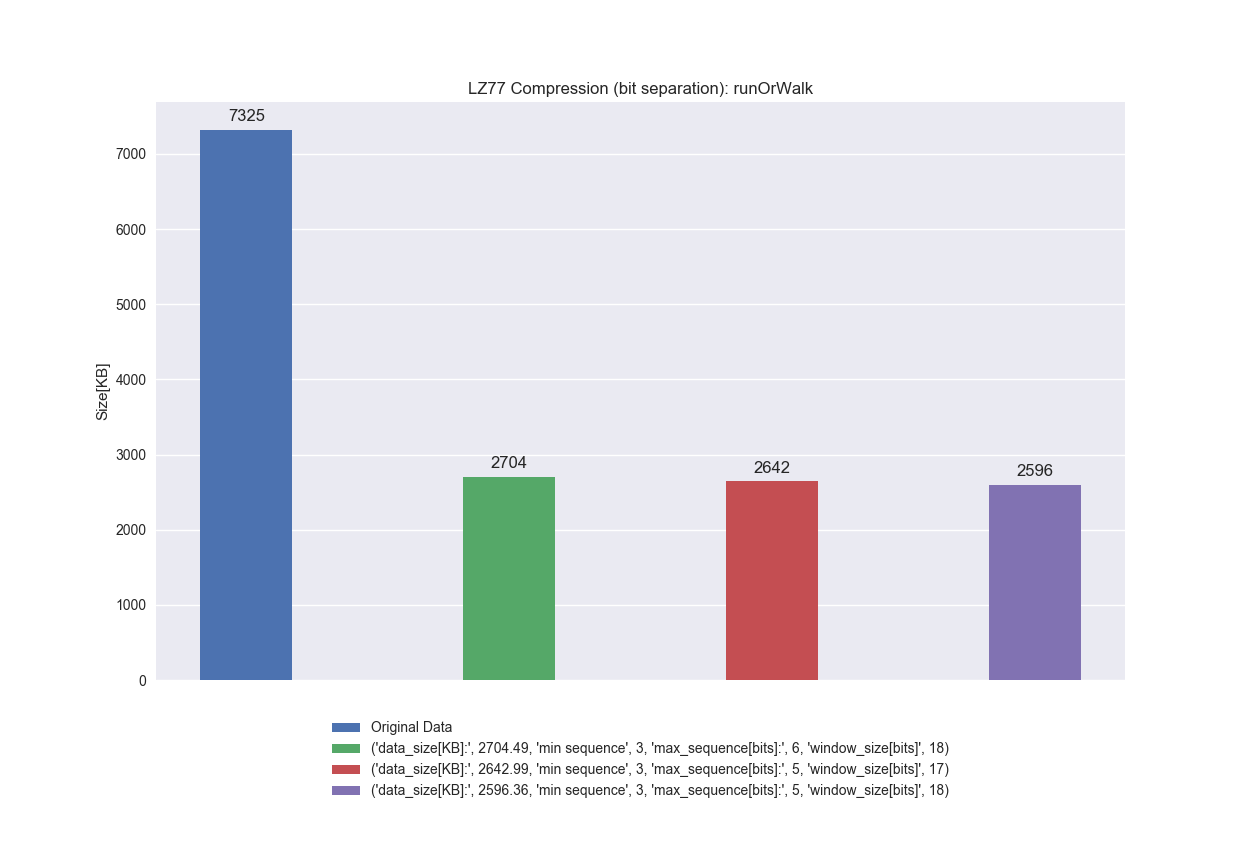
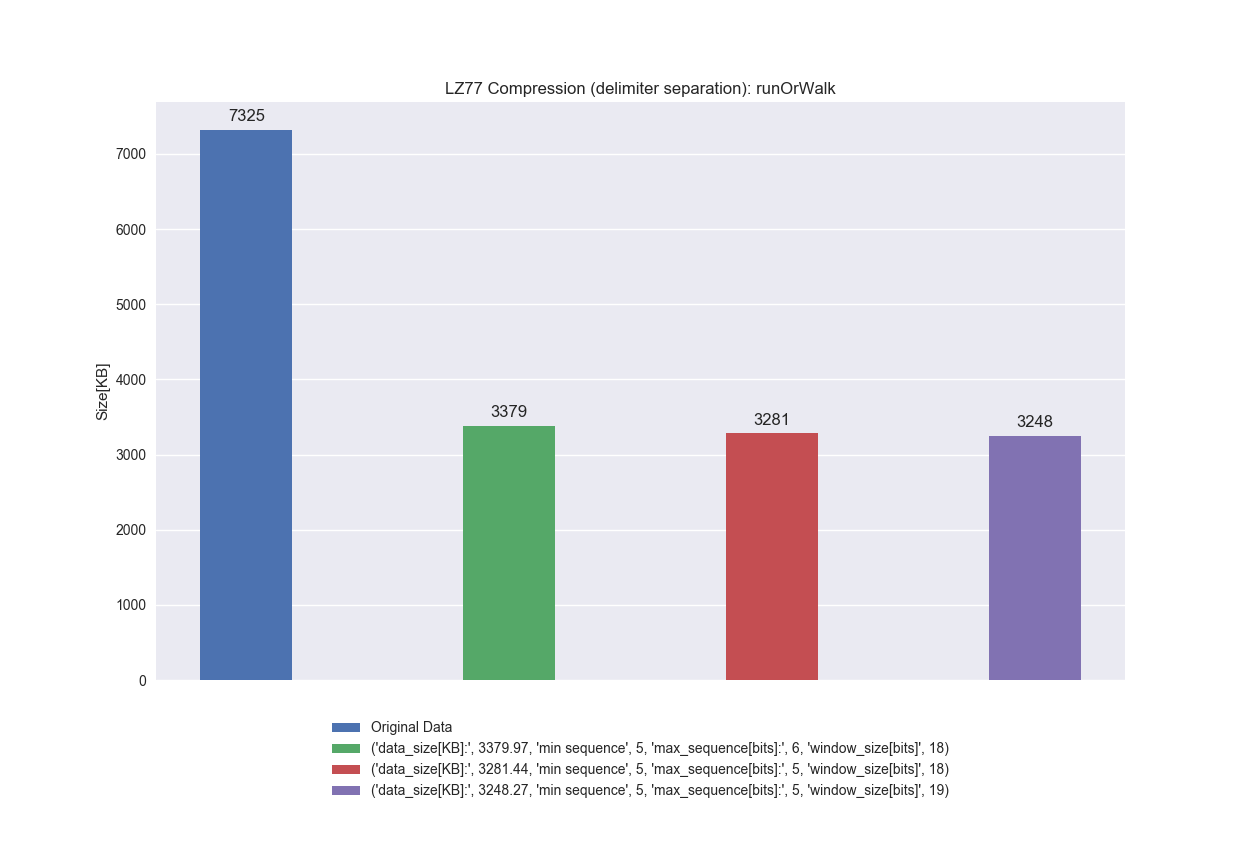

As we can see in case of the second method of **bit separation**:  
We get better Compression Ratio: [1.0, 0.37, 0.36, 0.35]  
The min length character to copy is 3 (the minimum we allow), the max bits to copy is 5(2^5-1+3=34 symbols to copy)  
And we get the best result when the window size is 18 bits(256kb) if we increase we pay in more  the overhead.  
In the 3 method of **delimiter separation**: 
The Compression Ratio: [1.0, 0.46, 0.45, 0.44] 
The min length character to copy is 5, (probably because of the overhead of the special symbol - 8 bits)  
And max sequence bits to copy is 5 (2^5-1 +5=36) , the optimize window size here 19 bits.  
For this data set the second method is better then the third, means we have a lot of short string to copy that the bit separations give batter result.  
Important notice that we didn't consider here the time simulation , for both cases the window size is extremely high 256Kb for bit separation and 512kb to delimiter separation , this window size will harm the performance of the algorithm.

### Data set 2 - Mobile location history of 10/2014 

In [4]:
### Parmaters for the mobileLocationHistory102014 Data set
data_file=['..\modified_data_sets\mobileLocationHistory102014\location_history_102014_v1.json']
train_set_file=['..\modified_data_sets\mobileLocationHistory102014\location_history_102014_v1_train_set.dat']
title=['Location_History_102014']
debug=True  #Debug mode -choose way data compressed is displayed
Fast_mode =True #Don't try all option of bit separation and symbole size
max_seq_bits=[[5,6]] #for fast mode  decide the range values for max_seq bits(length)
window_size_bits_s=[[17,18]]#for fast mode  decide the range values for window_size bits(offset)
window_size_bits_d=[[18,19]]#for fast mode  decide the range values for window_size bits(offset)

In [ ]:
from lz77_ext_func_bit_separation import LZ77_bit_separate
from lz77_ext_func_delimiter import LZ77_delimiter_separate
from my_LZ77 import LZ77

for i in range(len(data_file)):
    figure_i=2*i
    lz77_bit=LZ77_bit_separate(data_file[i],train_set_file[i],"LZ77 Compression (bit separation): "+title[i],Fast_mode,
                               max_seq_bits[i],window_size_bits_s[i],debug)
    lz77_bit.perform_compression_statistics(figure_i)

    lz77_delim=LZ77_delimiter_separate( data_file[i],train_set_file[i],"LZ77 Compression (delimiter separation): "+title[i],
                                        Fast_mode,max_seq_bits[i], window_size_bits_d[i])
    lz77_delim.perform_compression_statistics(figure_i+1)
plt.show()

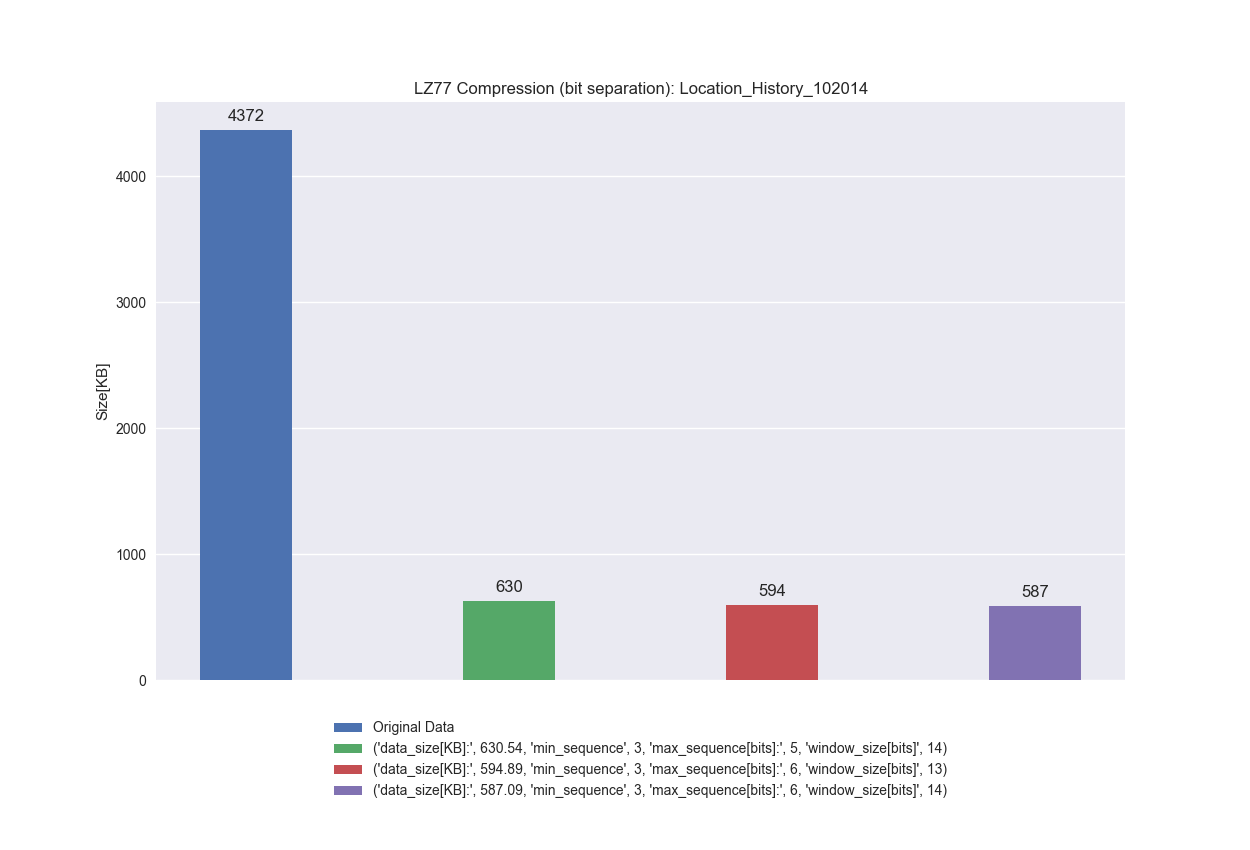
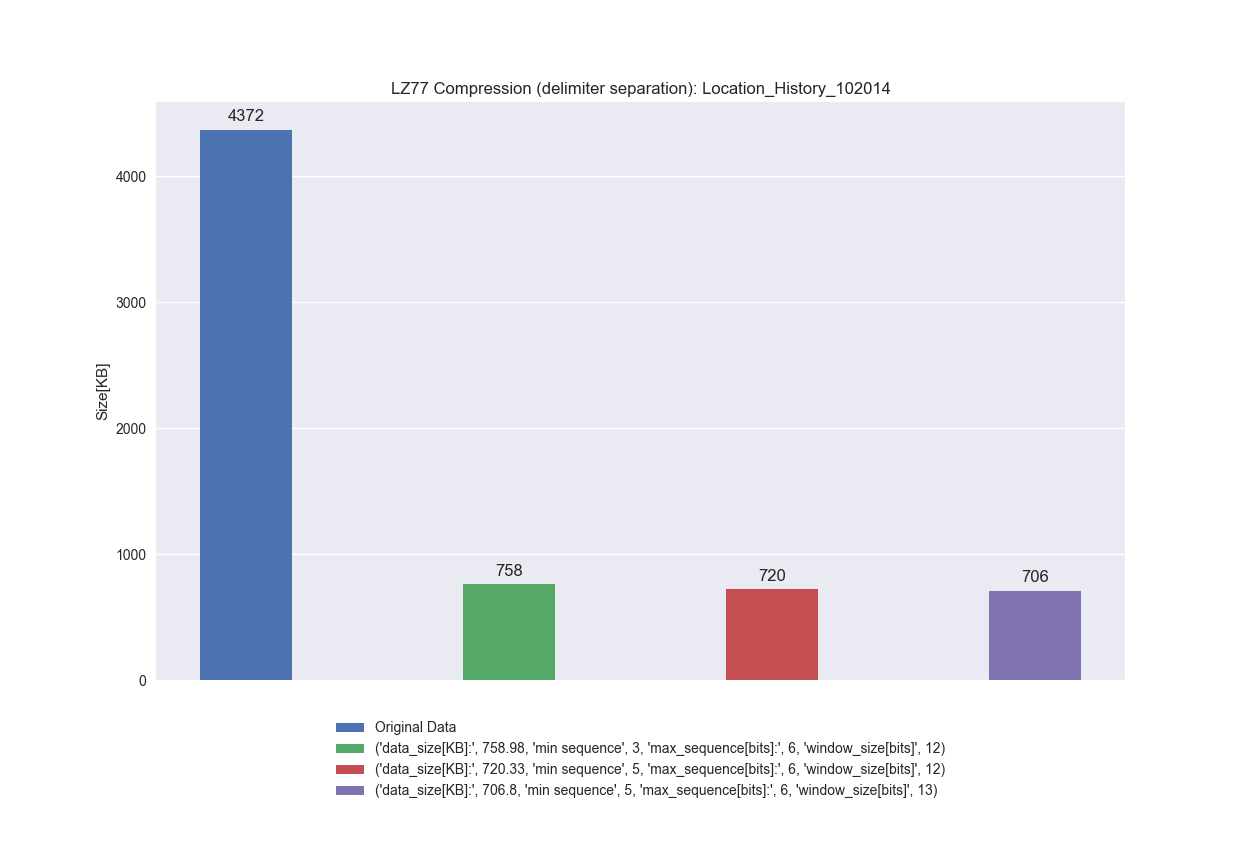

As we can see in case of the second method of **bit separation**:  
We get the best **Compression Ratio**: [1.0, 0.15, 0.14, 0.13]     
The min length character to copy is 3 (the minimum we allow) , the max bits to copy is 6(2^6+3=67 symbols to copy) 
and we get the best result when the window size is 14 bits[16 KB]  if we increase it we pay a lot for the overhead.  
In the 3 method of **delimiter separation** : [1.0, 0.175, 0.17, 0.166]   
The min length character to copy is 5,(probably because of the overhead of the special symbol - 8 bits)
And max sequence bit to copy is 6 (2^6+5=68) so it mean that we prefer in this data set to have a greater history on expense of character to copy.   
Also for this data set the bit separation is better , means we have a lot of short sequence to copy that the bit separations give batter result.

### Data set 3 - 2016 NYC Real Time Traffic Speed Data Feed  

In [ ]:
### Parmaters for the runOrWalk Data set
data_file=['..\modified_data_sets\\nyc2016\\april2016_v1.csv']
train_set_file=['..\modified_data_sets\\nyc2016\\april2016_v1_train_set.dat']
title=['nyc2016-april2016_v1']
debug=True  #Debug mode -choose way data compressed is displayed
Fast_mode =True #Don't try all option of bit separation and symbole size
max_seq_bits=[[5,6]] #for fast mode  decide the range values for max_seq bits(length)
window_size_bits_s=[[17,18]]#for fast mode  decide the range values for window_size bits(offset)
window_size_bits_d=[[18,19]]#for fast mode  decide the range values for window_size bits(offset)

In [ ]:
from lz77_ext_func_bit_separation import LZ77_bit_separate
from lz77_ext_func_delimiter import LZ77_delimiter_separate
from my_LZ77 import LZ77

for i in range(len(data_file)):
    figure_i=2*i
    lz77_bit=LZ77_bit_separate(data_file[i],train_set_file[i],"LZ77 Compression (bit separation): "+title[i],Fast_mode,
                               max_seq_bits[i],window_size_bits_s[i],debug)
    lz77_bit.perform_compression_statistics(figure_i)

    lz77_delim=LZ77_delimiter_separate( data_file[i],train_set_file[i],"LZ77 Compression (delimiter separation): "+title[i],
                                        Fast_mode,max_seq_bits[i], window_size_bits_d[i])
    lz77_delim.perform_compression_statistics(figure_i+1)
plt.show()

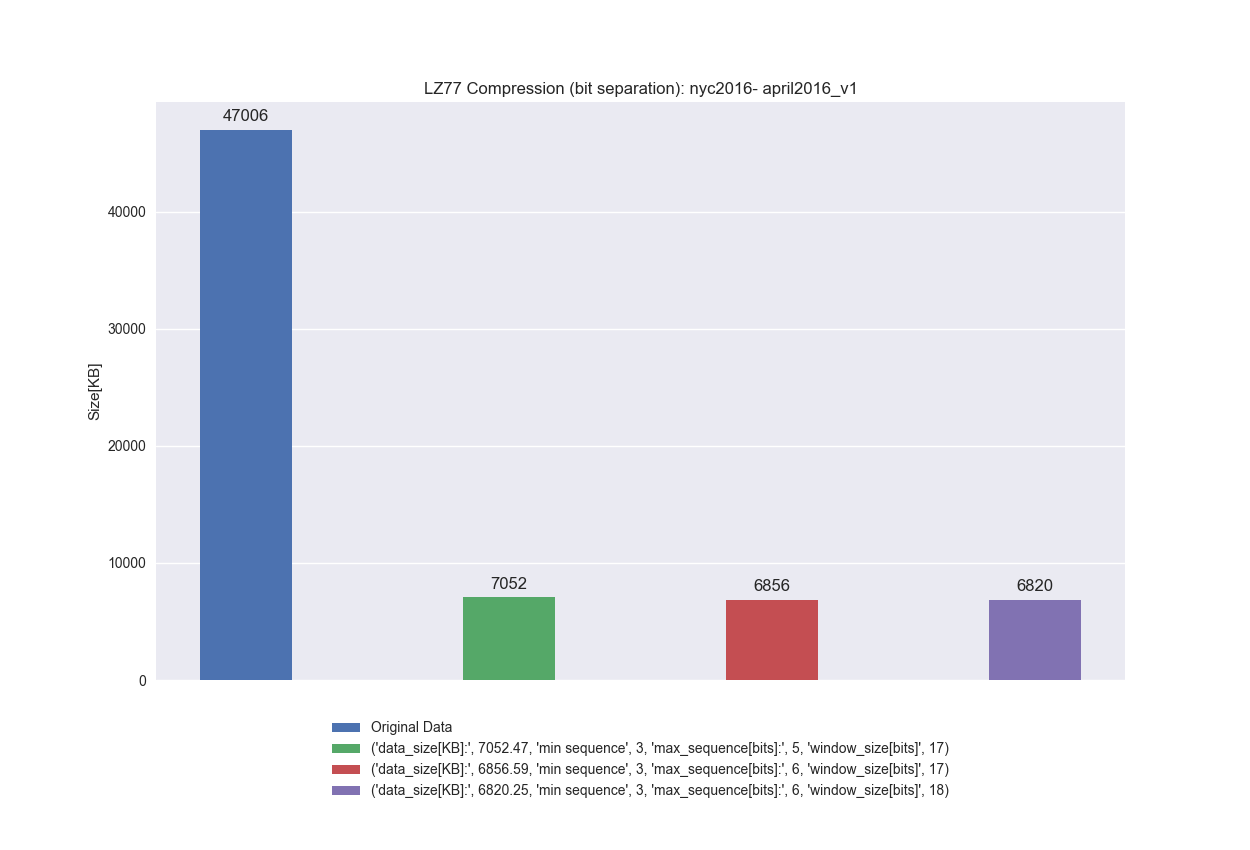
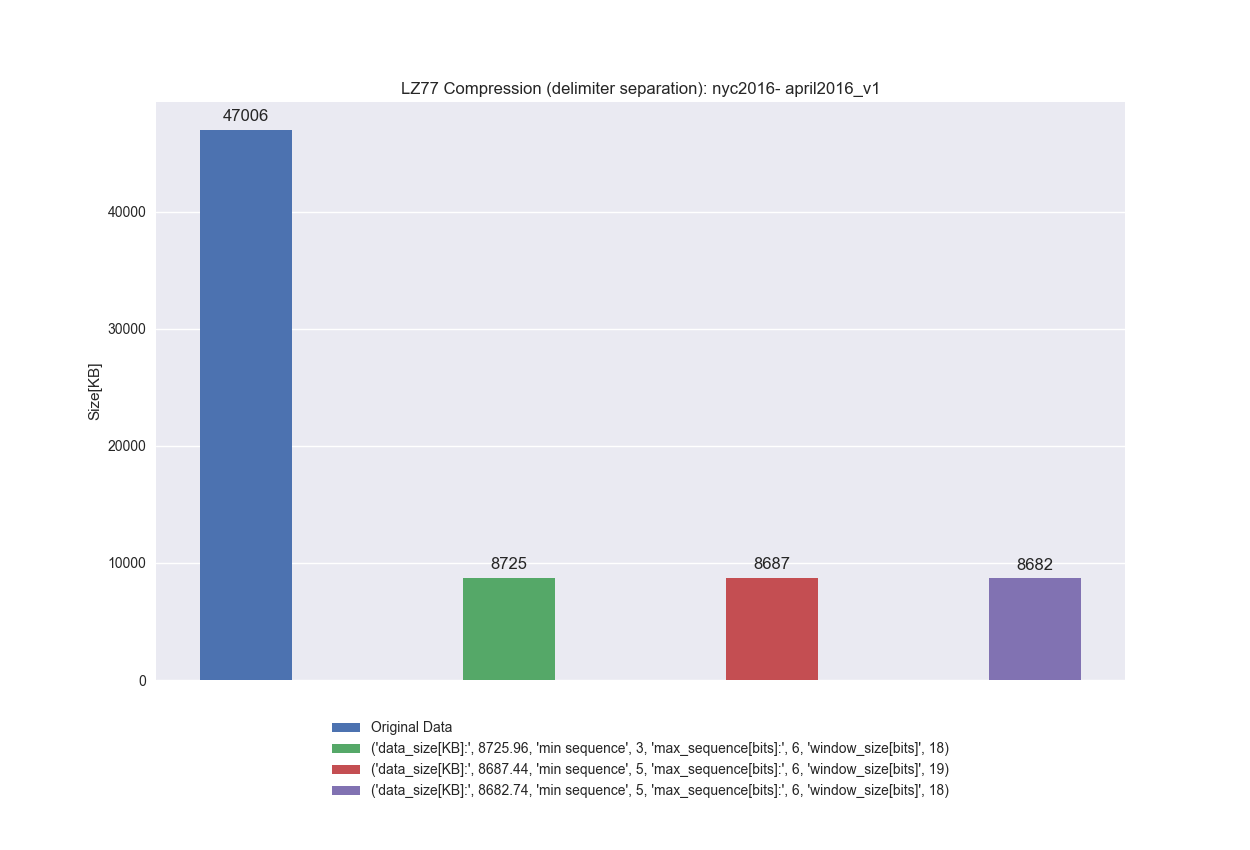

As we can see in case of the second method of **bit separation**:  
We get better Compression Ratio: [1.0, 0.15, 0.15, 0.15]  
The min length character to copy is 3 (the minimum we allow), the max bits to copy is 6(2^6-1+3=67 symbols to copy)  
And we get the best result when the window size is 18 bits(256kB) if we increase we pay in more  the overhead.  
In the 3 method of **delimiter separation**:  
The Compression Ratio: [1.0, 0.19, 0.18, 0.18] 
The min length character to copy is 5, (probably because of the overhead of the special symbol - 8 bits)  
And max sequence bits to copy is 5 (2^6-+5=68) , the optimize window size here 18 bits.  
For this data set the second method is better then the third, means we have a lot of short string to copy that the bit separations give batter result.  
Again we didn't consider here the time simulation , for both cases the window size is extremely high 256KB ,although we get for this parameters the best results this window size will harm the performance of the algorithm.

## Part 3 - Structured Compression And Clustered Huffman

In this part we show 5 ways of improvement to LZ77 and Huffman algorithms, we will try to decrease the output size and compression ratio by the following methods:  
1) **LZ77 and Huffman** - combine the 2 algorithms together like DEFLATE and GZIP.  
2) **LZ77 (separate: data, control,length,offset_high,offset_low) and Huffman** -split the result of the LZ77 to 5 different codes: data, control,length,offset_high,offset_low and perform Huffman on each of one of them.  
3) **Separated columns**- perform Huffman and LZ77 on each columns.  
4) **Clustered Huffman** - compares Huffman using machine learnings technique of clustering. (In the Last Part of the report).   
5) **LZ77 (separate: data, control,length,offset_high,offset_low) and Clustered Huffman**. (In the Last Part of the report).  

### <font color=blue> First method- LZ77 and hufmman </font>


Like GZIP and DEFLATE algorithms we try to combine Lempel-Ziv compression and Huffman coding together,  
as most of the algorithms we prefer to start with LZ77 first and then use Huffman.  
The reason is the big advantage LZ has over Huffman is in treating dependencies between symbols after using LZ77 the symbols are now independent events and ordered randomly, so then Huffman is simpler and works better in that case. doing the opposite will cause LZ to be much less effective because it rely on dependencies between sequential characters.

#### Data set 1  - Run Or Walk

In [ ]:
from huffman_and_lz77_ext_func import LZ77_huffman
data_file=['..\modified_data_sets\\runOrWalk\\runOrWalk_v1.csv']
train_set_file=['..\modified_data_sets\\runOrWalk\\runOrWalk_v1_train_set.dat']
title=['runOrWalk']
Fast_mode =True #Don't try all option of bit separation and symbole size
max_seq_bits=[[5,6]] #for fast mode  decide the range values for max_seq bits(length)
window_size_bits_s=[[17,18]]#for fast mode  decide the range values for window_size bits(offset)

for i in range(len(data_file)):
    figure_i=i
    lz77_and_huff_data_control = LZ77_huffman_data_control(data_file[i], train_set_file[i],\
                                "LZ77+Huffman compression (split data control): " + title[i],\
                                 Fast_mode, max_seq_bits[i], window_size_bits_s[i])
    lz77_and_huff_data_control.lz77_and_huffman_compression(figure_i)

plt.show()

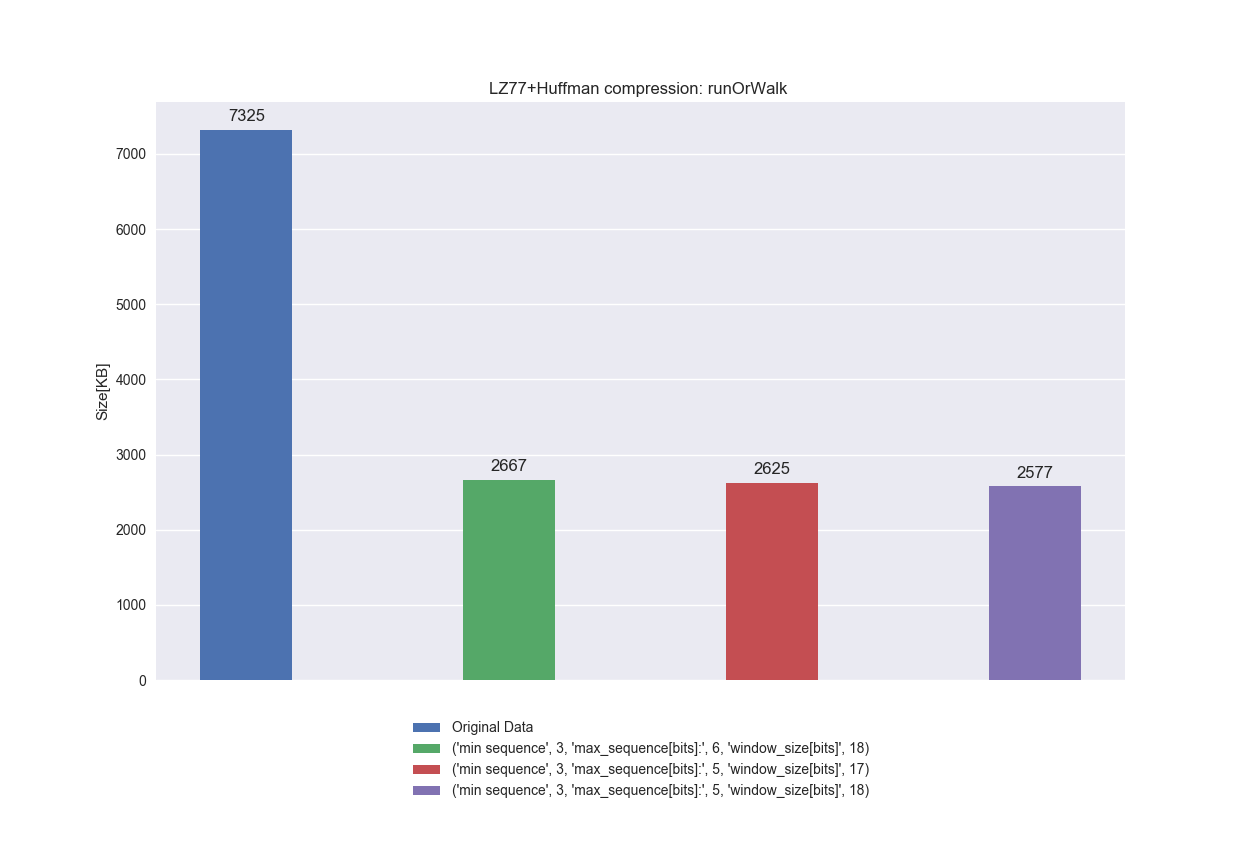

**Compression ratio**=[1.0, 0.36, 0.36, 0.35]  
As we can see we get batter result by combining LZ77 and Huffman from using simple Huffman algorithm or LZ77 algorithm alone.  
But the improvement between using LZ77 alone to LZ77+Huffman is small , the main reason is the way we implement the LZ77 with the bit separation that cause to each character to grow in one bit .  
The Huffman work on Chars(8 bits) so basically we increase a lot of the variance of the data by adding this bit and reduce the effective of the Huffman compression.

#### Data set 2 - Mobile location history of 10/2014 

In [ ]:
from huffman_and_lz77_ext_func import LZ77_huffman
data_file=['..\modified_data_sets\mobileLocationHistory102014\location_history_102014_v1.json']
train_set_file=['..\modified_data_sets\mobileLocationHistory102014\location_history_102014_v1_train_set.dat']
title=['Location_History_102014']
max_seq_bits=[[5,6]] #for fast mode  decide the range values for max_seq bits(length)
window_size_bits_s=[[17,18]]#for fast mode  decide the range values for window_size bits(offset)
for i in range(len(data_file)):
    figure_i=i
    lz77_and_huff_data_control = LZ77_huffman_data_control(data_file[i], train_set_file[i],\
                                "LZ77+Huffman compression (split data control): " + title[i],\
                                 Fast_mode, max_seq_bits[i], window_size_bits_s[i])
    lz77_and_huff_data_control.lz77_and_huffman_compression(figure_i)

plt.show()

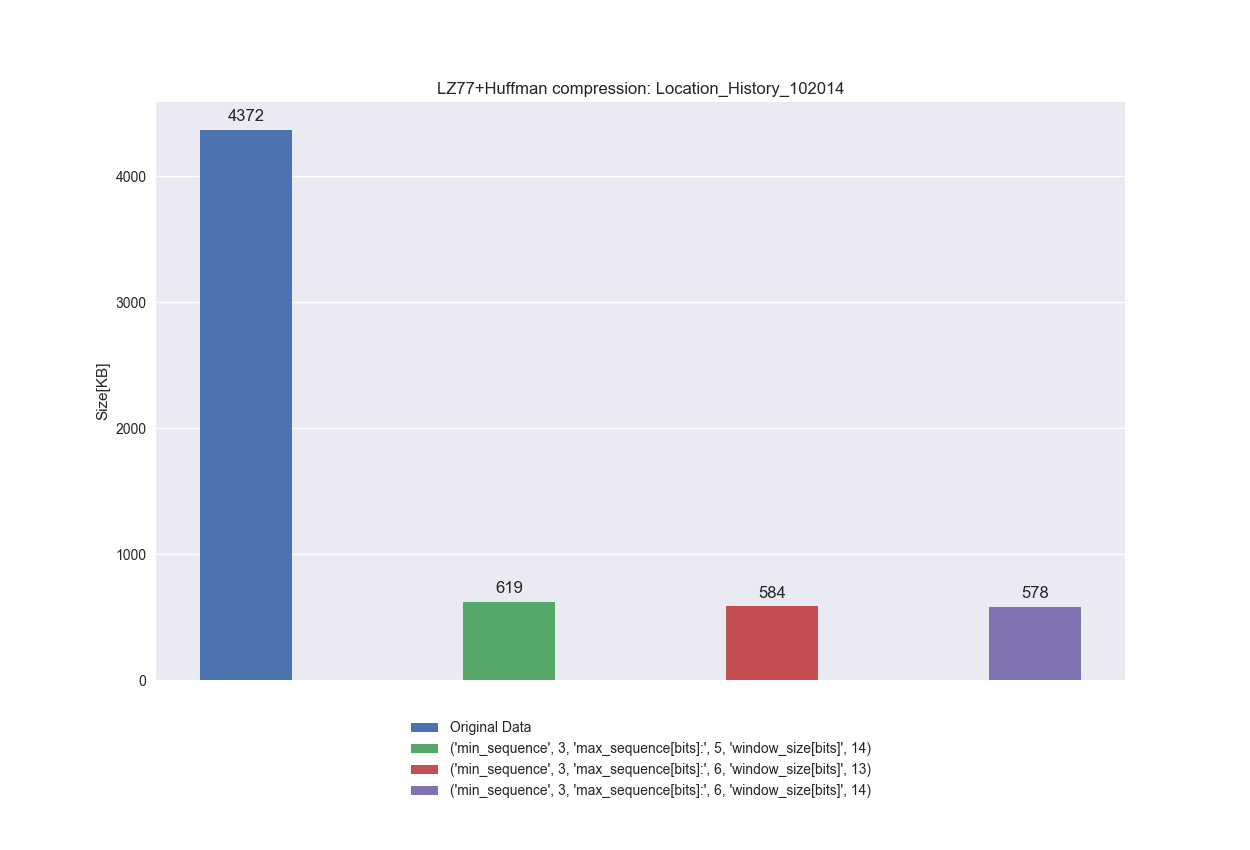

As we can see we get batter result by combining LZ77 and Huffman from using simple Huffman algorithm or LZ77 algorithm alone.  
Compression Ratio=0.13.  
But also in this case we can we can improve the compression, the main reason is the way we implement the LZ77 with the bit separation that cause to each character to grow in one bit .  
The Huffman work per char so basically we increase the variance of the data by adding this bit and reduce the effective of the Huffman compression.

### Data set 3 - 2016 NYC Real Time Traffic Speed Data Feed  

In [ ]:
from huffman_and_lz77_ext_func import LZ77_huffman
data_file=['..\modified_data_sets\\nyc2016\\april2016_v1.csv']
train_set_file=['..\modified_data_sets\\nyc2016\\april2016_v1_train_set.dat']
title=['nyc2016-april2016_v1']
Fast_mode =True #Don't try all option of bit separation and symbole size
max_seq_bits=[[5,6]] #for fast mode  decide the range values for max_seq bits(length)
window_size_bits_s=[[17,18]]#for fast mode  decide the range values for window_size bits(offset)
for i in range(len(data_file)):
    figure_i=i
    lz77_and_huff_data_control = LZ77_huffman_data_control(data_file[i], train_set_file[i],\
                                "LZ77+Huffman compression (split data control): " + title[i],\
                                 Fast_mode, max_seq_bits[i], window_size_bits_s[i])
    lz77_and_huff_data_control.lz77_and_huffman_compression(figure_i)

plt.show()

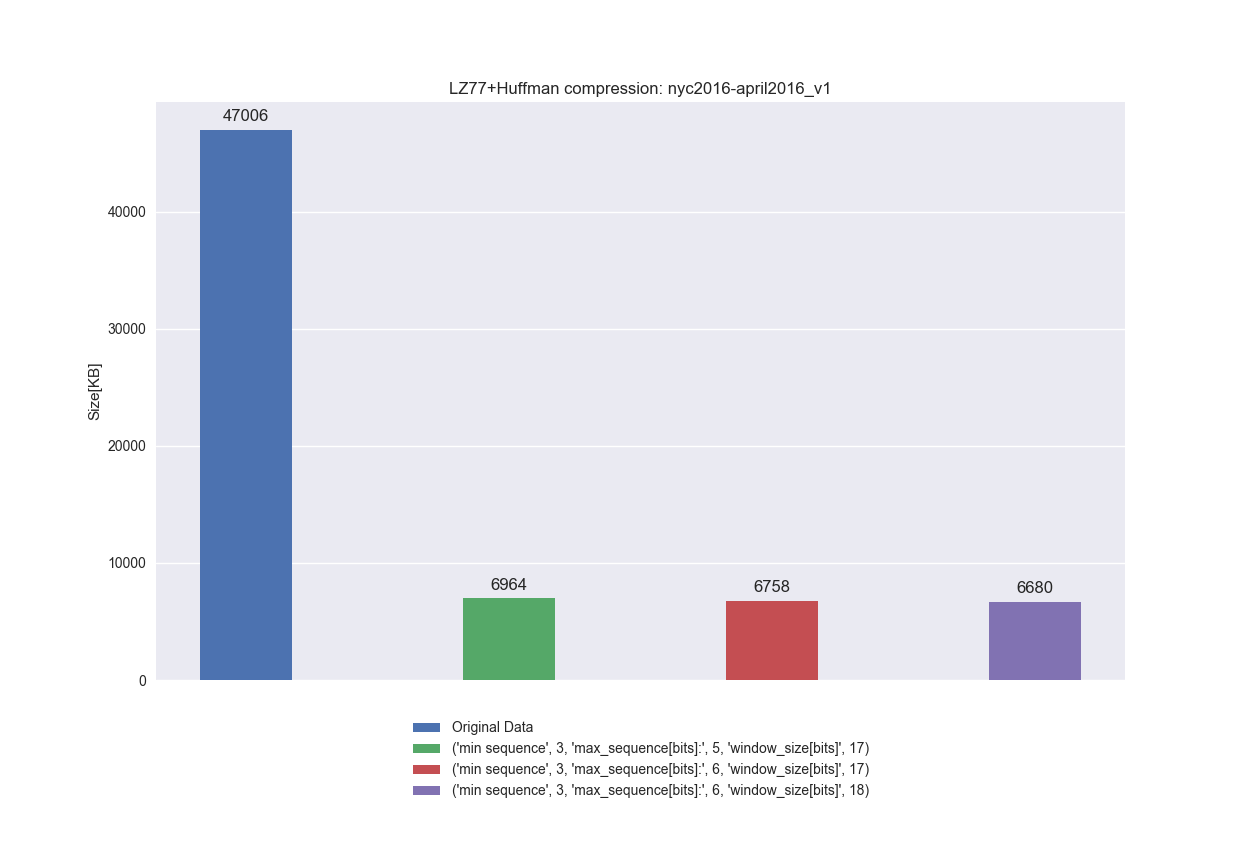

**Compression Ratio**: [1.0, 0.15, 0.14, 0.14]  
As we can see we get batter result by combining LZ77 and Huffman from using simple Huffman algorithm or LZ77 algorithm alone.
But the also in this case improvement is small ,the main reason is the way we implement the LZ77 with the bit separation that cause to each character to grow in one bit .  
The Huffman work on a char so basically we increase a lot of the variance of the data by adding this bit and reduce the effective of the Huffman compression.


### <font color=blue> Second method- LZ77 and Huffman ( separate data ,control,length,offset_high,offset_low)</font>

In the First method we saw that Huffman stage didn't improve a lot the LZ77 algorithms,  
the reason is the additional bit we add for each character and the Huffman work on every 8 bits(char) so by this method of compressing we increase a lot the variance of the data and harm the effectiveness of Huffman.
As far as we understand the GZiP algorithm LZ  use 32KB offset field (15 bit) and maximum 256 sequence length (8 bit), it them use one Huffman code for the pure literals and the sequence length fields, and one Huffman code for the offset.
We decided to take more radical approach and split coding to data ,control,length,offset_high,offset_low channels each compressed with it's own Huffman tree:
* **Data**- we have now char(that will decrease the variance of the data).  
* **Control**- we have '0' or '1'- 0 means pure character and '1' start of [length,distance] pair.  
* **Length**(bit)- maximum sequence to copy.  
* **offset_high **(bit)- maximum window size first 8 higher bits.  
* **offset_low **(bit)- maximum window size lower bits bits.  

The reason to split the offset to 8 higher bits and other lower bits is our assumption that lower bits contains almost uniform distribution of values but the higher bits that represent much far distance will provide useful information for compression (we will see that this assumption was correct). 
Now we perform Huffman on each of new outputs separately. 

#### Data set 1  - Run Or Walk

In [ ]:
from huffman_and_lz77_data_control_ext_func import LZ77_huffman_data_control
data_file=['..\modified_data_sets\\runOrWalk\\runOrWalk_v1.csv']
train_set_file=['..\modified_data_sets\\runOrWalk\\runOrWalk_v1_train_set.dat']
title=['runOrWalk']
Fast_mode =True #Don't try all option of bit separation and symbole size
min_seq=[4,5,6] # minimum sequnce to copy
max_seq_bits=[[8,8]] #for fast mode  decide the range values for max_seq bits(length)
window_size_bits_s=[[16,16]]#for fast mode  decide the range values for window_size bits(offset)

for i in range(len(data_file)):
    figure_i=i
    lz77_and_huff_data_control = LZ77_huffman_data_control(data_file[i], train_set_file[i],\
                                "LZ77+Huffman compression (split data control): " + title[i],\
                                 Fast_mode, max_seq_bits[i], window_size_bits_s[i],min_seq[i])
    lz77_and_huff_data_control.lz77_and_huffman_compression(figure_i)

plt.show()

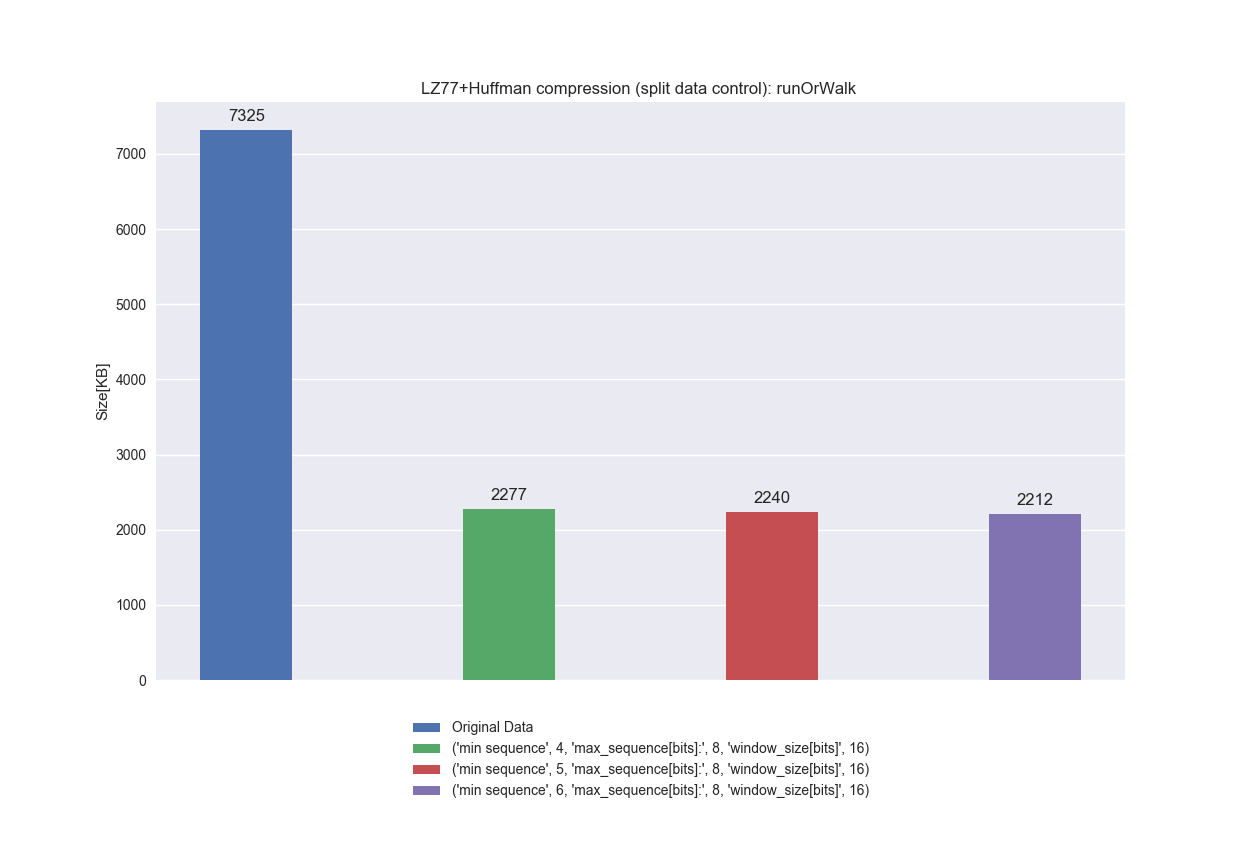

*Compression Ratio*: [1.0, 0.31, 0.31, 0.3].  
Now after we split the data ,control,offset_high,offset_low,length we can  that the Huffman compression in the second phase give batter results.  
The most interesting part here that the best results  we get(after checking variance of inputs in slow mode option) is for window_size=16[bit] (64 KB) and max_sequence=8[bit] ,  as opposed to LZ alone results which prefered higher sizes.
The reason rely on the fact that Huffman is most effective on the data/length fields, and performing to strong LZ reduce Huffman effectiveness.
Another interesting point in that case the that we prefer to increase the min sequence by this we prefer to decrease the variation of the Huffman and expense saving bits by replacing it  with a pointer.  
Also we get improvement in time simulation because decreasing the windows size bits, and parallelize the Huffman compression.  
The main conclusions for this part:  
The best compression result can't be done by using greedy algorithm in LZ77, Instead we need to get the best compression that keep small variance with size bits that divide by char(8 bits) so the Huffman will be more effective.  
We need to find the compression balance between LZ77 to Huffman.


#### Data set 2 - Mobile location history of 10/2014 

In [ ]:
from huffman_and_lz77_data_control_ext_func import LZ77_huffman_data_control
data_file=['..\modified_data_sets\mobileLocationHistory102014\location_history_102014_v1.json']
train_set_file=['..\modified_data_sets\mobileLocationHistory102014\location_history_102014_v1_train_set.dat']
title=['Location_History_102014']
min_seq=[4,5,6] # minimum sequnce to copy
max_seq_bits=[[8,8]] #for fast mode  decide the range values for max_seq bits(length)
window_size_bits_s=[[8,8]]#for fast mode  decide the range values for window_size bits(offset)
for i in range(len(data_file)):
    figure_i=i
    lz77_and_huff_data_control = LZ77_huffman_data_control(data_file[i], train_set_file[i],\
                                "LZ77+Huffman compression (split data control): " + title[i],\
                                 Fast_mode, max_seq_bits[i], window_size_bits_s[i],min_seq[i])
    lz77_and_huff_data_control.lz77_and_huffman_compression(figure_i)

plt.show()

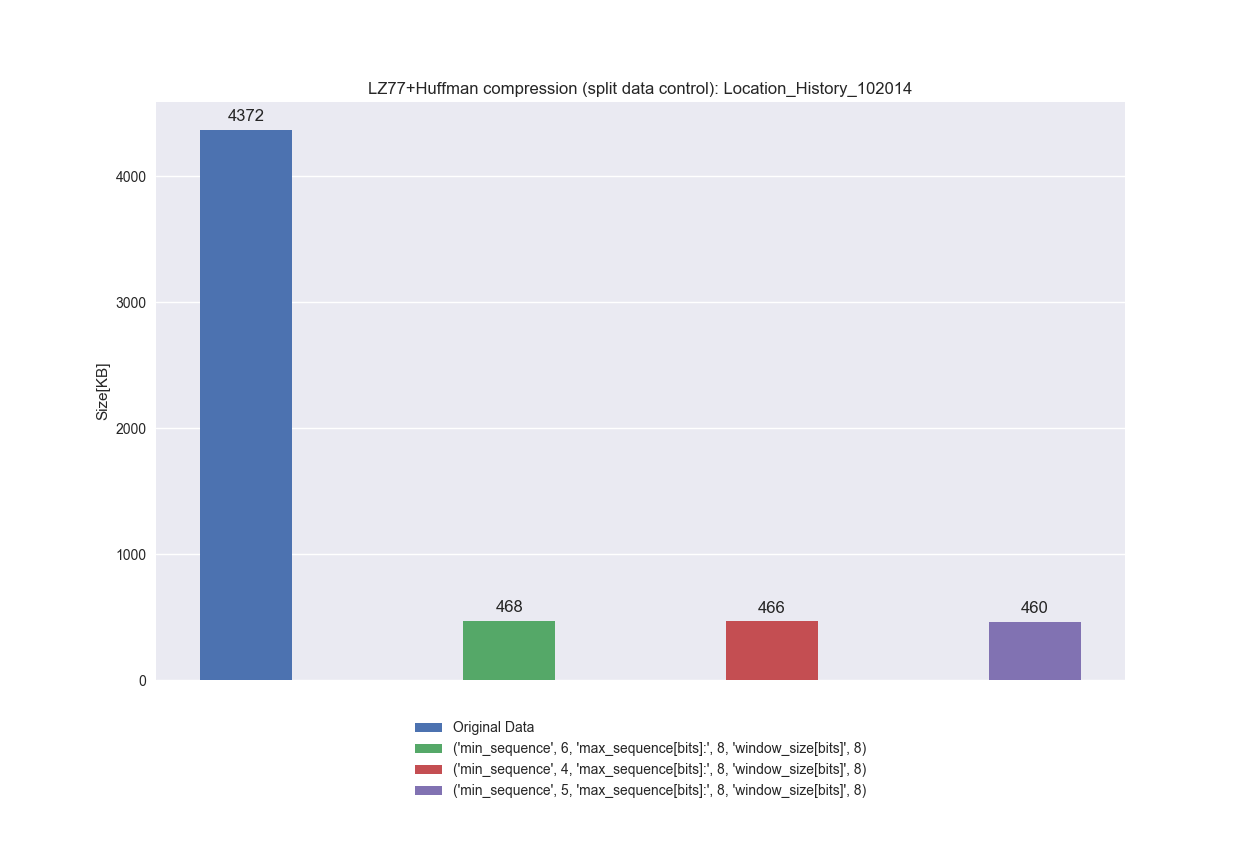

**Compression Ratio**: [1.0, 0.11, 0.11, 0.1].  
Now after we split the data ,control,offset_high,offset_low,length we can  that the Huffman compression in the second phase give better results.  
Also here the best results we get(after checking variance of inputs in slow mode option) is for window_size=8[bit] (256B) and max_sequence=8[bit] ,  
the reason again is the Huffman work on char(8 bits) and for this parameters we get that Huffman is the most effective on windows_size and max_sequence.  
In this case we see again that we prefer to not maximize the LZ77 compression for getting the best result Instead we need to get the best compression that keep small variance with size bits that divide by char(8 bits) so the Huffman will be more effective. 
Also we get improvement in time simulation because decreasing the windows size bits, and parallelize the Huffman compression.  
In  we get the same conclusion like the last part that we need to find the compression balance between LZ77 to Huffman.


#### Data set 3 - 2016 NYC Real Time Traffic Speed Data Feed  

In [ ]:
from huffman_and_lz77_data_control_ext_func import LZ77_huffman_data_control
data_file=['..\modified_data_sets\\nyc2016\\april2016_v1.csv']
train_set_file=['..\modified_data_sets\\nyc2016\\april2016_v1_train_set.dat']
title=['nyc2016-april2016_v1']
Fast_mode =True #Don't try all option of bit separation and symbole size
min_seq=[4,5,6] # minimum sequnce to copy
max_seq_bits=[[8,8]] #for fast mode  decide the range values for max_seq bits(length)
window_size_bits_s=[[16,16]]#for fast mode  decide the range values for window_size bits(offset)

for i in range(len(data_file)):
    figure_i=i
    lz77_and_huff_data_control = LZ77_huffman_data_control(data_file[i], train_set_file[i],\
                                "LZ77+Huffman compression (split data control): " + title[i],\
                                 Fast_mode, max_seq_bits[i], window_size_bits_s[i],min_seq[i])
    lz77_and_huff_data_control.lz77_and_huffman_compression(figure_i)

plt.show()

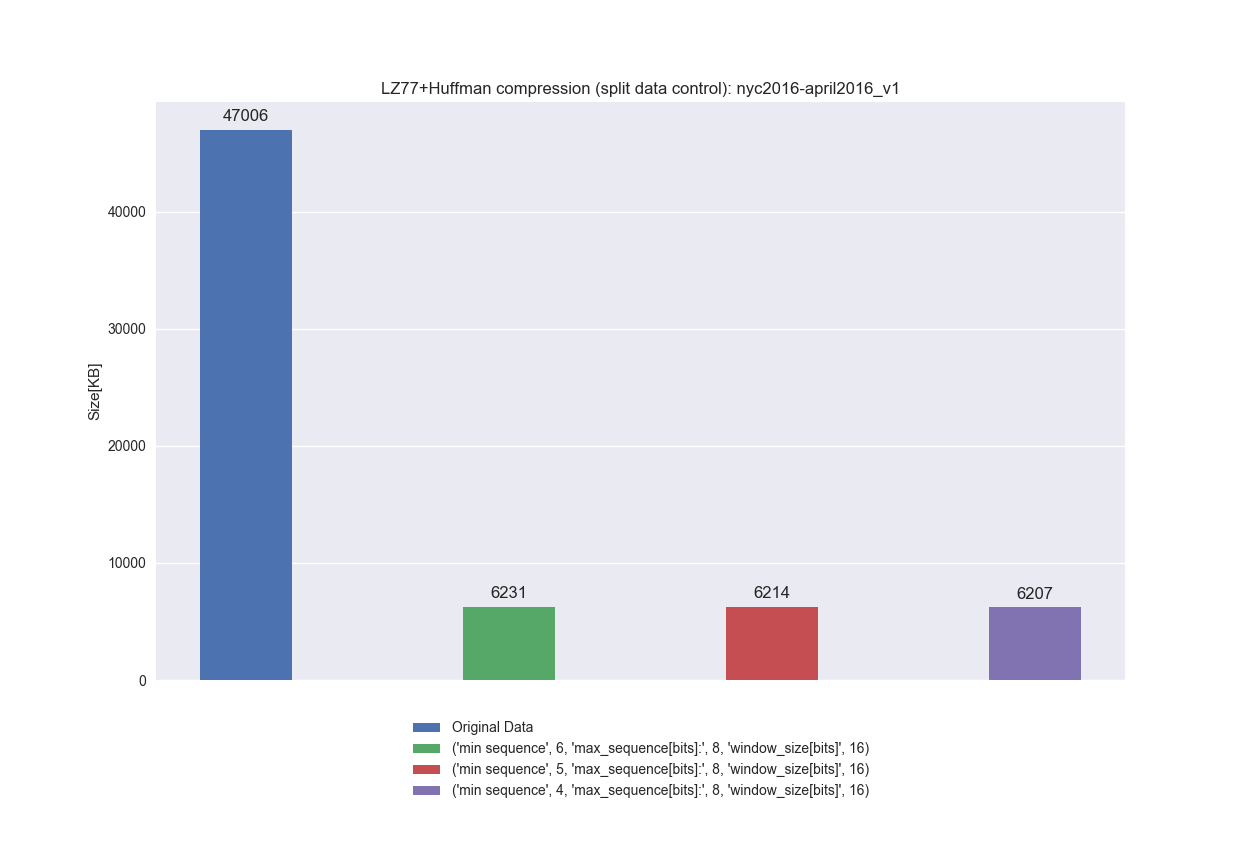

**Compression Ratio**: [1.0, 0.13, 0.13, 0.13].  
Now after we split the data ,control,length,offset_high,offset_low we can  that the Huffman compression in the second phase give better results.  
Also here the best results we get(after checking variance of inputs in slow mode option) is for window_size=16[bit] (64KB) and max_sequence=8[bit] ,  
the reason again is the Huffman work on char(8 bits) and for this parameters we get that Huffman is the most effective on windows_size and max_sequence.
In this case we see again that we prefer to not maximize the LZ77 compression for getting the best result Instead we need to get the best compression that keep small variance with size bits that divide by char(8 bits) so the Huffman will be more effective. 
Also we get improvement in time simulation because decreasing the windows size bits, and parallelize the Huffman compression.  
In  we get the same conclusion like the last part that we need to find the compression balance between LZ77 to Huffman.


### <font color=blue> Third method-Separation column</font>

Another try is to use the algorithm compression for each column.
In this case the variance of the data should be much smaller and the effective of both algorithms will be grater, this way of compression should improve our compression ratio.  
In this section we had another parameter (equal) to set if we use separate only by columns or separate by any other delimiter we find in the data (this mode is less effective when the columns is not equals)

In [20]:
import math

class LZ77(object):
    
    def __init__(self, min_sequence, sequence_length_bits, window_size_bits):
        # type: (object, object) -> object
        self.min_sequence = min_sequence
        self.sequence_length_bits = sequence_length_bits
        self.max_sequence = pow(2, sequence_length_bits) + self.min_sequence - 1
        self.window_size_bits = int(window_size_bits)
        self.window_size = pow(2, window_size_bits)-1
        self.length_format = '{:0%sb}' % sequence_length_bits
        self.offset_format = '{:0%sb}' % window_size_bits

    def compress(self, data, debug=None):
        
        compressed_data = ''
        compressed_control = ''
        compressed_offset_high = ''
        compressed_offset_low = ''
        compressed_length = ''
        window = ''

        i = 0
        while i < len(data):
            seq_len = 1
            while i + seq_len <= len(data) and seq_len <= self.max_sequence and data[i:i + seq_len] in window:
                seq_len += 1

            seq_len -= 1
            if seq_len >= self.min_sequence and data[i:i + seq_len] in window:
                offset = len(window) - window.rfind(data[i:i + seq_len])
                compressed_control += '1'
                compressed_offset_high += self.offset_format.format(offset)[0:8]
                compressed_offset_low += self.offset_format.format(offset)[8:]
                compressed_length += self.length_format.format(seq_len)
                window += data[i:i + seq_len]
                i += seq_len
            else:
                compressed_control += '0'
                compressed_data += data[i]
                window += data[i]
                i += 1

            window = window[-self.window_size:]
        
        compressed_control = self.decode_binary_string(compressed_control)
        compressed_length = self.decode_binary_string(compressed_length)
        compressed_offset_high = self.decode_binary_string(compressed_offset_high)
        compressed_offset_low = self.decode_binary_string(compressed_offset_low)
        return compressed_data, compressed_control,compressed_offset_high, compressed_offset_low, compressed_length
    
    #convert binary stream to sring
    def decode_binary_string(self,s):
        str=''.join(chr(int(s[i*8:i*8+8],2)) for i in range(len(s)/8))
        return str if (len(s)%8 == 0) else str+(chr(int(s[-(len(s)%8):],2)))


#### Data set 1  - Run Or Walk

In [ ]:
from separate_column_ext_func import *
data_file=['..\modified_data_sets\\runOrWalk\\runOrWalk_v1.csv']
train_set_file=['..\modified_data_sets\\runOrWalk\\runOrWalk_v1_train_set.dat']
title=['runOrWalk']
Fast_mode =True #Don't try all option of bit separation and symbole size
equal=True
max_seq_bits=[[5,6]] #for fast mode  decide the range values for max_seq bits(length)
window_size_bits_s=[[17,18]]#for fast mode  decide the range values for window_size bits(offset)

for i in range (len(data_file)):
    figure_i=i
    compress = separate_columns_compress(data_file[i], train_set_file[i], "LZ77+Huffman compression (split columns): " + title[i],
                                    Fast_mode, max_seq_bits[i], window_size_bits_s,equal[i])
    compress.separate_columns_compression(figure_i)
plt.show()

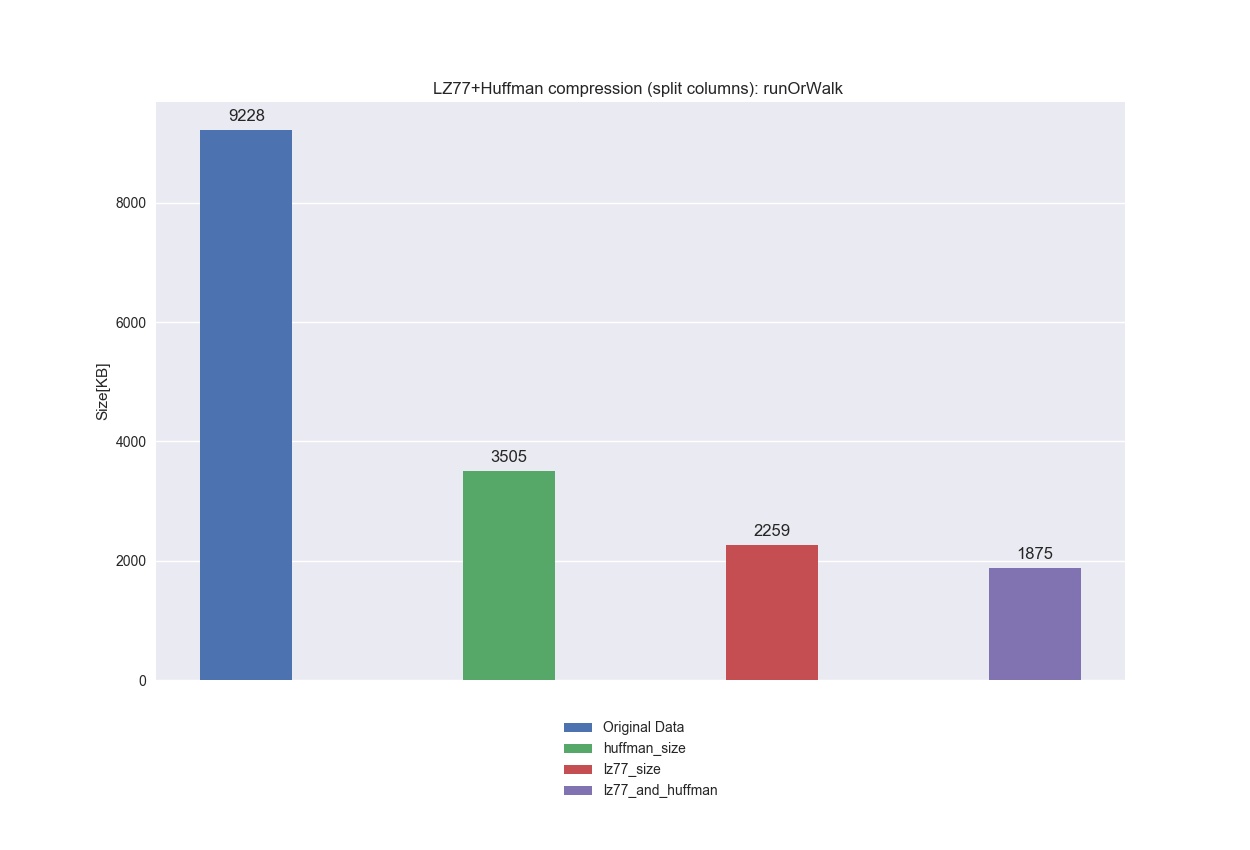

As we expected by separate to column the variance of each column of data is smaller and also the compression ratio  comparing using all data and we get much better result:  
**Huffman**- compression_ratio= 0.38 compare to compression_ratio=0.45 in case of compressing all data.  
**LZ77** - compression_ratio= 0.24 compare to compression_ratio=0.35 in case of compressing all data.  
**LZ77 and Huffman** - compression_ratio= 0.2 compare to compression_ratio=0.33 in case of compressing all data.
Also the simulation run-time for this case can significantly improve if we using parallel computing ,  
the disadvantage for this is that the data should be in fixed template (that every sample have the same field).   

#### Data set 2 - Mobile location history of 10/2014 

Another try is to use the algorithm compression for each column.  
The json file have different fields and if we transform the data to columns we get that each part have not equal columns. 
(some time-stamp for example have not just longitude and latitude but also accuracy).
For this part we change our data we use and we put the json into columns to fit the algorithm .  
In this case now the reference of the original data size=1728[KB]

In [ ]:
from separate_column_ext_func import separate_columns_compress
#################################
### main
#################################
data_file=['..\modified_data_sets\mobileLocationHistory102014\location_history_102014_v1.json']
train_set_file=['..\modified_data_sets\mobileLocationHistory102014\location_history_102014_v1_train_set.dat']
title=['Location_History_102014']
equal=[False] #equal columns
max_seq_bits=[[5,6]] #for fast mode  decide the range values for max_seq bits(length)
window_size_bits_s=[[17,18]]#for fast mode  decide the range values for window_size bits(offset)
for i in range (len(data_file)):
    figure_i=i
    compress = separate_columns_compress(data_file[i], train_set_file[i], "LZ77+Huffman compression (split columns): " + title[i],
                                    Fast_mode, max_seq_bits[i], window_size_bits_s[i])
    compress.separate_columns_compression(figure_i)
plt.show()

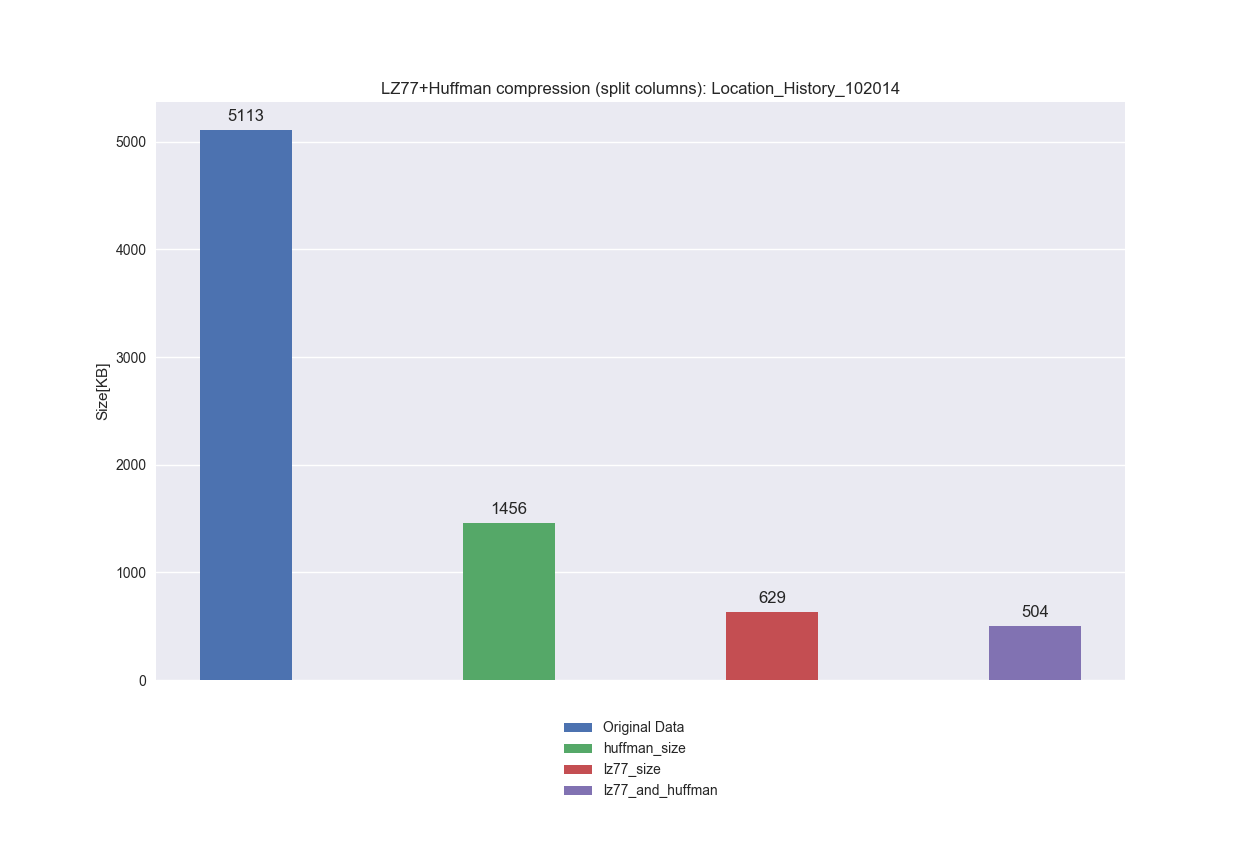

In this case the separation columns didn't improve the compression ratio, it even harm it. (the original data is 1728[KB] but after reshape it to columns it  increase to 5113[Kb])
As we can see by using this method we almost tripled the data size of the original  (because we need to place every element in the columns if it was empty we replace it with a comma).  
We can see that some columns that in the beginning didn't include more than 20 bytes (contain small really smal data)  
but with this method they increased to to 20KB.  
Compression ratio of all data:  
**Huffman** - compression ratio= 0.83(from original size) compare to compression ratio=0.6 in case of compressing all data.  
**LZ77** - compression ratio= 0.35(from original size) compare to compression ratio=0.12 in case of compressing all data.  
**LZ77 and Huffman** - compression ratio= 0.32(from original size) compare to compression ratio=0.1 in case of compressing all data.  
For conclusion it is batter not to use this method for Json data.

### Data set 3 - 2016 NYC Real Time Traffic Speed Data Feed  

Another try is to use the algorithm compression for each column.  
In this case the variance of the data should be much smaller and the effective of both algorithms will be grater, this way of compression should improve our compression ratio.  
In this part we not only split by columns but also special characters that can apear in the data like: floating point '/' or '-' in dates and ':' in times 

In [ ]:
from separate_column_ext_func import separate_columns_compress
data_file=['..\modified_data_sets\\nyc2016\\april2016_v1.csv']
train_set_file=['..\modified_data_sets\\nyc2016\\april2016_v1_train_set.dat']
title=['nyc2016-april2016_v1']
Fast_mode =True #Don't try all option of bit separation and symbole size
max_seq_bits=[[5,6]] #for fast mode  decide the range values for max_seq bits(length)
window_size_bits_s=[[17,18]]#for fast mode  decide the range values for window_size bits(offset)
equal=[True]

for i in range (len(data_file)):
    figure_i=i
    compress = separate_columns_compress(data_file[i], train_set_file[i], "LZ77+Huffman compression (split columns): " + title[i],
                                    Fast_mode, max_seq_bits[i], window_size_bits_s[i],equal[i])
    compress.separate_columns_compression(figure_i)
plt.show()

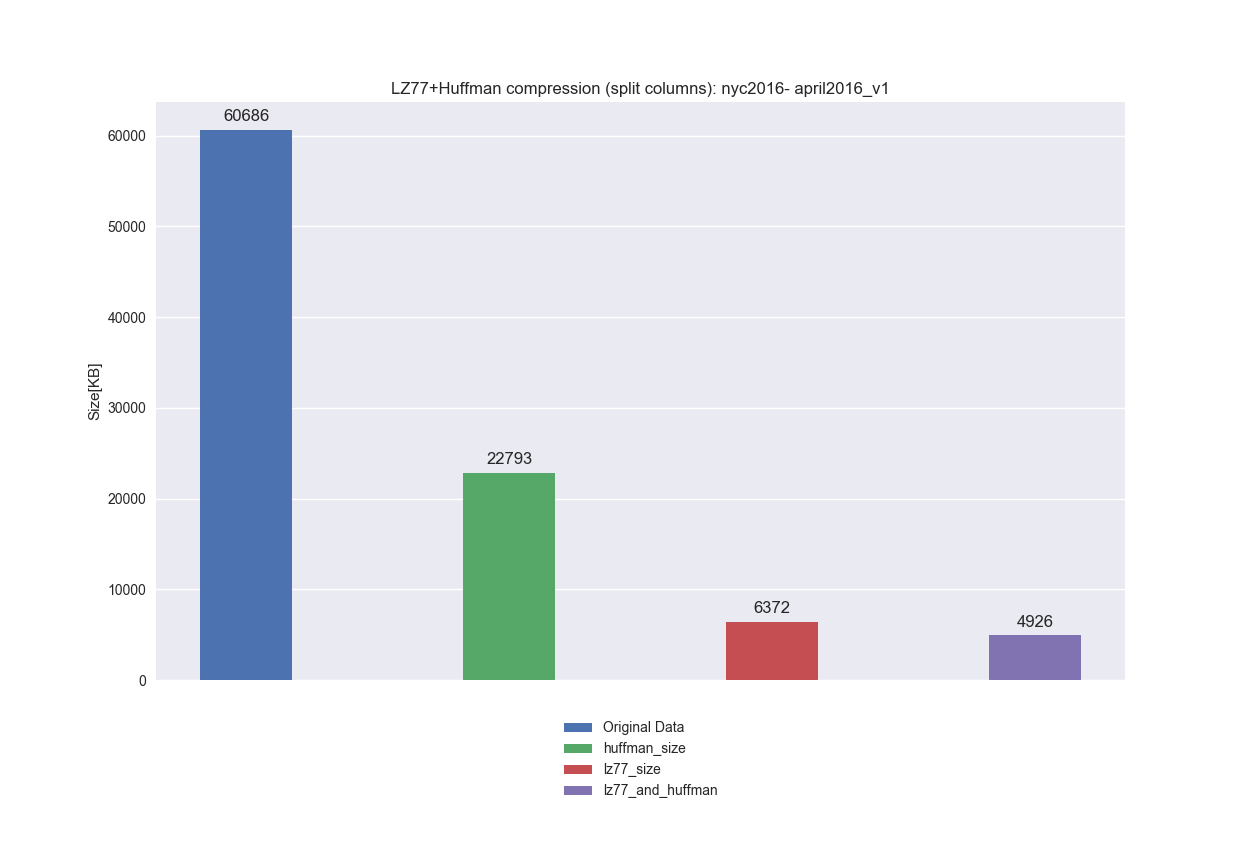

As we expected by separate to column the variance of each column of data is smaller and also the compression ratio  comparing using all data and we get much better result:  
**Huffman**- compression_ratio= 0.38 compare to compression_ratio=0.47 in case of compressing all data.  
**LZ77** - compression_ratio= 0.1 compare to compression_ratio=0.15 in case of compressing all data.  
**LZ77 and Huffman** - compression_ratio= 0.08 compare to compression_ratio=0.136 in case of compressing all data.
Also the simulation run-time for this case can significantly improve if we using parallel computing ,  
the disadvantage for this is that the data should be in fixed template (that every sample have the same field). 
And we saw cases like the data set before that this method can't be used.

## Clustered Huffman
### Motivation
The regular Huffman code treat the data set as unified source with constant character frequencies. Our assumption is that if we split our data sets to small enough partitions, there will be different characters frequencies. Such difference can occur due several reasons:  
1. Rows with different labels: for example in RunOrWalk maybe records labeled 'walk' contains more zeros on the acceleration sensors compared to records labeled run.  
2. Spatial locality: there are data sets where close records will contain similar data, for example, in the NYC traffic sensors, the average cars speed change between hours on a day time  
3. Correlation between columns of records: records may contains columns with have some correlation, for example in RunOrWalk when records contains 'run' label we can assume that the gravity sensors on x and y axis contains higher values then the average.  
4. Unstructured data/semi structured data: when records fields doesn't deterministic there is higher probability to get different character frequency for different row. for example looking on our mobile JSON data set, there are records that contains extra keys/values information (as described on the first section of our work).  
5. Seasonal/Trends data set: there are data sets which aren't stationary over time hence different partitions of such sets from different hours/days/month etc. will contains different character frequencies. 
6. Random noise: in some parts, specially small parts, we will get frequency derive different Huffman code.  

With those assumption, our intent is to exploit this frequency variance across partitions and achieve better compression results by using multiple Huffman codes per data set. 

### Naive Methods
Naive solution such Huffman code per block will fail due the fact that each dictionary need to be transmitted too and will cause hundred bits overhead per partition, to cover this overhead we will need a very big partitions size which may decrease the variance between partitions (it may still success in seasonal data sets).  
Another more sophisticated approach will be to analyze the data set and take advantage of some features in order to  build several different Huffman codes and activate them according this analysis.  

A simple example would be our mobile location data set, this data set represented as JSON format where some records contains time-stamps, latitude, longitude and accuracy, but some of the records contains extra fields with predefined set of keys. In this case construct two different Huffman dictionaries for each type of record would make sense.  

Although this approach can achieve good results, it have very big dis-advantage, it requires experts/heavy analysis and worth, it isn't generalized for specific set of rules, for example some data sets may have correlation between columns, some may decided by length of record and some may decided by time of record (seasonal).
  
### The Clustered Huffman Algorithm
#### Idea
We would like to propose a new method named Clustered Huffman compression, an unsupervised multiple Huffman codes compression algorithm that exploit the variance of character frequencies over data set and yet doesn't need expert per data set.    
In previous methods we used optimal Huffman codes per partition. In our algorithm we compromise the optimal code per partition and instead choose "best" Huffman code among given trees (soon the "best" will explained). 

#### Huffman codes construction
The Huffman trees built from running clustering algorithm over character frequencies that represent partitions samples taken from the data set.
The partitioning operation perform according partitioning_rules, for example each x characters, or each y line breaks.
The building phase return both the n_clusters Huffman codes and the clusters estimator which will be used also in the encoding process.  
#### Encoding
In order to encode a data set we first divide the data set to partitions according partition_rules (described in previous paragraph). for each partition we estimate Huffman tree and encode the partition with it. to the compressed data we need to add bits represent the chosen Huffman tree.
An important thing to emphasize is that the partitions_rules doesn't need to be same as the partition_rules used for the construction phase, for example, they may differ they may both different count of line breaks. In the experiment chapter we will try to understand if this flexibility is really necessary.  

#### Decoding 
The decode performed by iterating over the encoded data, where first we read which Huffman tree to use, than decode with it till partition finished according given partition_rules, and repeat those two stages till all encoded data set decoded.
In this stage we do required to supply same partition_rules given in the encoding phase, that because we use this rule solely to understand when Huffman tree need to be switched.

#### Detailed algorithms:
1. **Build(data_set, n_clusters, partitioning_rules):**
  2.   get the full_character_set in the data_set
  3.   divide the data sets to partitions P according partitioning_rules
  4.   for each p_i in P construct s_i character frequency vector
  5.   for each s_i in S, for each character c appear on full_character_set and not in s_i, add to s_i {c:0.0}
  6.   run clustrring algorithm on S and save n_clusters centroids C  
  7.   for each c in C construct Huffman codes H(c)  <br/>
8. **Encode(data_set, partitioning_rules):  **
  9.   divide the data sets to partitions P according partitioning_rules
  10.  for each p_i in P: 
    11.    construct s_i character frequency vector  
    12.    find closest centroid c from C
    13.    encode p_i with H(c) to en_p_i
    14.    add centroid c index concatenate with en_p_i to encode_data_set
  15.  return encode_data_set  <br/>
  
16. **Decode(encode_data_set, partitiong_rules):**
  17.  while didn't pass all encode_data_set:
    18.    read centroid index c from encode_data_set
    19.    add H(c) to decode_data_set until partitioning_rules holds
  20.  return decode_data_set<br/>



In [21]:
import collections
import math
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from IPython.display import display
import random

pd.options.display.max_columns = None


class ClusteredHuffman(object):
    
    def __init__(self, **kwargs):
        """
        params:
          sample_seperator: which event represent seperator between samples, 
                            if None, works in character level (for one liner data-sets such our reformatted json)
          batch_size: how many samples grouped to represent freq sample to the clustring algorithm
          stop_chars: chars to ignore/skip
        """
        self.sample_seperator = kwargs['sample_seperator']
        self.train_batch_size = kwargs['train_batch_size']
        assert self.train_batch_size > 0
        self.stop_chars = kwargs['stop_chars']
        self.n_clusters = kwargs['n_clusters']
        self.fill_missing_chars = kwargs['fill_missing_chars'] if 'fill_missing_chars' in kwargs else True
        self.data_set_is_file_path = kwargs['data_set_is_file_path'] if 'data_set_is_file_path' in kwargs else True
        self.verbose = kwargs['verbose'] if 'verbose' in kwargs else True
        self.train_fraction = kwargs['train_fraction'] if 'train_fraction' in kwargs else None
        
        self.est = None
        self.full_char_set = None
        self.h_arr = None
        self.train_labels_count = None
        self.cluster_bits_rep = math.ceil(math.log(self.n_clusters,2))
    
    def info(self, msg):
        if self.verbose is True:
            print msg
    
    def encode(self, data_set_file, batch_size):
        self.info('encode dataset...')
        
        #TODO: add dictionaries to the enccoding... (for the analysis we use compression_info_file)
        #for h in self.h_arr:
        #    huff_dicts += h.get_dict_size()
            
        clustr_bits = '{:0%sb}' % self.n_clusters
        encode_stream = ''
        for f, curr_chars in self._get_sample(self.get_data_stream(data_set_file), batch_size, True):
            label = int(self.est.predict(f.reshape(1,-1)))
            encode_stream += cluster_bits.format(label)
            encode_stream += self.h_arr[label].encode(curr_chars)

        self.info('done encoding!')
        return encode_stream
        
    
    def get_data_stream(self, data_set_file):
        if self.data_set_is_file_path:
            return itertools.chain.from_iterable(open(data_set_file))
        return data_set_file
    
    def get_dicts_size(self):
        huff_dicts = 0.
        for h in self.h_arr:
            huff_dicts += h.get_dict_size()
        return huff_dicts
    
    def compression_info_file(self, data_set_file, batch_size):
        self.info('calculate compression info...')
        uncompressed = 0
        compressed = 0
        huff_dicts = 0.
        for f, curr_chars in self._get_sample(self.get_data_stream(data_set_file), batch_size, True):
            label = int(self.est.predict(f.reshape(1,-1)))
            curr_uncomp, curr_comp, dict_size = self.h_arr[label].compression_info(curr_chars)
            uncompressed += curr_uncomp
            compressed += curr_comp + self.cluster_bits_rep
        huff_dicts = self.get_dicts_size()
        return compressed, uncompressed, huff_dicts
    
    def print_compression_info_file(self, data_set_file, batch_size):
        compressed, uncompressed, huff_dicts = self.compression_info_file(data_set_file, batch_size)
        header = ['uncompressed[b]', 'compressed[b]', 'dictionaries[b]', 'neto compression ratio', 'compression ratio']
        table = [[uncompressed, compressed, huff_dicts, compressed / uncompressed, (compressed + huff_dicts) / uncompressed]]
#         print 'uncompressed: %s, compressed(without codes): %s, codes: %s, ratio(without codes): %s, total ratio: %s' %(uncompressed, compressed, huff_dicts, compressed / uncompressed, (compressed + huff_dicts) / uncompressed)
        print_table(header, table)
        return compressed, uncompressed, huff_dicts
            
    
    def get_huffman_dicts_lengths(self):
        table = []
        table.append(self.full_char_set[:])
        for h in self.h_arr:
            c_len = [str(len(h.get_code()[c])) for c in self.full_char_set]
            table.append(c_len)
        return table
    
    def print_huffman_dicts_lengths(self):
        table = self.get_huffman_dicts_lengths()
        for row in table:
            print '%s' %(' '.join(row))
    
    def pprint_huffman_dicts_lengths(self):
        table = self.get_huffman_dicts_lengths()
        headers = table.pop(0)
        print_table(headers, table)
    
    def pprint_train_labels_count(self):
        headers = [i for i in range(len(self.train_labels_count))]
        print_table(headers, [self.train_labels_count])
    
    def build_codes(self, data_set_file):
        self.info('calculate full char set...')
        self.full_char_set = self._get_char_set(self.get_data_stream(data_set_file))
        self.info('build clustring samples...')
        cluster_samples = self._get_cluster_samples(self.get_data_stream(data_set_file), self.train_batch_size)
        if self.train_fraction is not None:
            self.info('#full sample size %s' % len(cluster_samples))
            cluster_samples = random.sample(cluster_samples, int(self.train_fraction * len(cluster_samples)))
        self.info('#samples: %s' % len(cluster_samples))
        self.info('clustring samples...')
        est = KMeans(n_clusters=self.n_clusters)
        self.est = est
        est.fit(cluster_samples)
        h_arr = []
        np.set_printoptions(precision=2)
        for i, c in enumerate(est.cluster_centers_):
#             print 'centroid %s: %s' % (i, c)
            freq_dict = {self.full_char_set[i]:c[i] for i in range(len(self.full_char_set))}
            h = Huffman(self.stop_chars)
            h.generate_code_from_freq_dict(freq_dict)
            h_arr.append(h)
        self.h_arr = h_arr
        self.info('huffman dicts code length comparrison:')
        if self.verbose:
                  self.pprint_huffman_dicts_lengths()

        labels = est.predict(cluster_samples)
        self.train_labels_count = []
        for i in range(self.n_clusters):
            self.train_labels_count.append(len([l for l in labels if l == i]))
        #print 'labels_count: %s' % self.train_labels_count
        if self.verbose:
                  self.pprint_train_labels_count()
    
    def get_train_labels_count(self):
        return self.train_labels_count
    
    def _get_cluster_samples(self, char_stream, batch_size):
        samples = []
        for f, _ in self._get_sample(char_stream, self.train_batch_size, False):
            samples.append(f)
        return samples
    
    def _get_sample(self, char_stream, batch_size, get_reminder):
        count = 0
        curr_batch = []
        for c in char_stream:
            if c in self.stop_chars:
                continue
            curr_batch.append(c)
            if c == self.sample_seperator or self.sample_seperator is None:
                count += 1
            if count == batch_size:
                freq_vec = self._get_freq(curr_batch)
                yield freq_vec, curr_batch
                count = 0
                curr_batch = []
                
        if get_reminder:
            if len(curr_batch) > 0:
                self.info('_get_sample fetched last partial sample length %s chars' % len(curr_batch))
                yield self._get_freq(curr_batch), curr_batch
                count = 0
                curr_batch = []
        else:
            if len(curr_batch):
                self.info('_get_sample drop last remainder sample length %s chars' % len(curr_batch))
            
    def _get_freq(self, char_stream):
        assert self.full_char_set is not None
        
        count_dict = dict(Counter(char_stream))
        for c in self.stop_chars:
            if c in count_dict:
                del count_dict[c]
        char_set = set([c for c in count_dict.keys()])
        if char_set != set(self.full_char_set):
            if self.fill_missing_chars:
                for c in self.full_char_set:
                    if c not in count_dict:
#                         print 'fill missing char %s in sample' % c
                        count_dict[c] = 0
            else:
                raise ValueError('need to support missing chars (maybe add some constant epsilon freq for those missings)')
        total = float(sum([v for v in count_dict.values()]))
        return np.array([count_dict[k] / total for k in self.full_char_set])
    
    def _get_char_set(self, char_stream):
        char_set = set()
        for c in char_stream:
            if c not in self.stop_chars:
                char_set.add(c)
        return list(char_set)


### Trade-offs 
There are several trade-off levels need to discussed:
1. First of all, the effectiveness of this method rely on the variance of character frequencies between partitions. For very homogeneous data sets we may not find better solution than the single optimal Huffman code.
2. Construction partitions size can also affect, two big partition may smooth spike frequency variances and will reduce clustering impact. Two small cluster will may not fetch full length of phenomena and will also reduce clustering impact. 
3. The number of centroids effect on several things: 
  1. Number of Huffman codes needed to be transmitted. this is a constant size and in very big data sets we can assume that it's effect will be negligible. 
  2. Each encoded partition prefixed with the centroid id, which is $log(clusters)$.
  3. For every data set there is the optimal number of clusters, too less/much clusters will cause to less effective compression.
4. encoding partition size can have same impact as the construction partition size limitation but add another trade-off, each partition include prefix with log(n_clusters) length, hence, for small partitions it will pay more prefix bits on total, and even for very distinct clusters it may be waste due low count of such clusters.  
5. Complexity: perform clustering requires extra operation on the data. Optimal k-means is NP Hard, and for fixed k clusters, d (samples dimensions) is $O(n^{dk+1})$.  
However we used Lloyd algorithm which is $O(nkdi)$ where i represent converge iterations. consider our empirical typical parameters (d ~ 10-100,k ~ 8-64, i ~ 50-100) the clustering itself will take resources, but doesn't scale exponentially and it is still practical.  
Encoding run time also perform more operations, each sample need to measure it distance for each centroid. The total complexity is $O(ndk)$ (refer to original complexity as $O(n)$) and was practical in our setup (dk ~ 50-5000)


### Experiments
In this section we will evaluate the Clustered Huffman algorithm in several scenarios:
1. Run it on each of our modified data sets compared to the regular Huffman code.
2. Evaluate it on the data symbols of our LZ implementation on RunOrWalk data set and compare it to our GZIP implementation.

In [22]:
#some helper functions for the experiments
import os
import pickle

def evaluate_clustered_huffman(data_set_file, seperator, stopers, train_batch_sizes, n_cluster_sizes, encode_sizes, target_file, train_fraction=None):
    if os.path.isfile(target_file):
        with open(target_file, 'r') as fr:
            res = pickle.loads(fr.read())
            return res
    
    res = {}
    for train_size in train_batch_sizes:
        res[train_size] = {}
        for cluster_size in n_cluster_sizes:
            print 'building train_size: %s, n_cluster: %s' % (train_size, cluster_size)
            res[train_size][cluster_size] = {}            
            ch = ClusteredHuffman(sample_seperator=seperator, train_batch_size=train_size, stop_chars=stopers, n_clusters=cluster_size, fill_missing_chars=True, verbose=False, train_fraction=train_fraction)
            ch.build_codes(data_set_file)
            res[train_size][cluster_size]['train_labels_count'] = ch.get_train_labels_count()
            res[train_size][cluster_size]['huffman_lengths'] = ch.get_huffman_dicts_lengths()
            for encode_size in encode_sizes:
                print 'encoding encode_size: %s' % (encode_size)
                res[train_size][cluster_size][encode_size] = ch.compression_info_file(data_set_file, encode_size)
    with open(target_file, 'w') as fw:
        pickle.dump(res, fw)
    return res

def get_df_result(res):
    header = ['train_size', 'n_clusters', 'encode_size', 'neto compression ratio', 'compression ratio']
    table = []
    for ts in res.keys():
        for nc in res[ts].keys():
            for es in res[ts][nc].keys():
                if es != 'train_labels_count' and es != 'huffman_lengths':
                    nratio = res[ts][nc][es][0] / res[ts][nc][es][1]
                    ratio = (res[ts][nc][es][0] + res[ts][nc][es][2]) / res[ts][nc][es][1]
                    table.append([ts, nc, es, nratio, ratio])
    return pd.DataFrame(table, columns=header)
           
def print_df_result(res):
    pd.options.display.max_columns = None
    display(get_df_result(res))

def color_positive_green(val, pivot):
    color = 'green' if val < pivot else 'black'
    return 'color: %s' % color

def highlight_max(data, color='red'):
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

def highlight_min(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

def result_style_chain(res, pivot_val, **kwargs):
    apply_max = kwargs['apply_max'] if 'apply_max' in kwargs else True
    apply_min = kwargs['apply_min'] if 'apply_min' in kwargs else True
    min_idx = kwargs['min_idx'] if 'min_idx' in kwargs else 0
    max_idx = kwargs['max_idx'] if 'max_idx' in kwargs else 100000
    sorter = kwargs['sorter'] if 'sorter' in kwargs else 'neto compression ratio'
    styler = res.sort_values(sorter).iloc[min_idx:max_idx].style.applymap(lambda x: color_positive_green(x,pivot_val), subset=['neto compression ratio', 'compression ratio'])
    if apply_max:
        styler = styler.apply(highlight_max, subset=['neto compression ratio', 'compression ratio'])
    if apply_min:
        styler = styler.apply(highlight_min, subset=['neto compression ratio', 'compression ratio'])
    return styler



#### Expirement 1 - Clustered Huffman vs. regular Huffman code
##### Run Or Walk
We decided to separate samples by line breaking sign. We run the clustered Huffman with cross between (train_size: 1,10,100,1000) x ( n_clusters: 2,4,8,16,32,64) x (encode size: 1,10,100,1000) total of 96 results from 96 parameter combinations. The clusters number choose in order to utilize all prefix bits on the encode data set.
The full table can be found on the appendix section

In [23]:
#exp 1 1
EXP_1_RUN_OR_WALK_RESULTS = '../output/experiments/exp1/exp1_run_or_walk_results.txt'
train_sizes = [1,10,100,1000]
n_cluster_sizes = [2,4,8,16,32,64]
encode_sizes = [1,10,100,1000]
run_or_walk_results = evaluate_clustered_huffman(RUN_OR_WALK_REFORMAT_V1_PATH, '\n', [], train_sizes, n_cluster_sizes, encode_sizes, EXP_1_RUN_OR_WALK_RESULTS)
run_or_walk_df = get_df_result(run_or_walk_results)

The regular Huffman achieved 0.506721 net (without dict) compression ratio and 0.506728 total ratio.  
The best Clustered Huffman net ratio achieved 0.505138 with parameters (train_size, n_clusteres, encode_size)=(100, 64, 100) which is 0.16% below the original.    
It is interesting in the top five results that 4 best results compression rates achieved with 64 clusters, means the clusters really catch variance between samples character frequency, it may imply that we also needed to run 128 clustering.

In [24]:
result_style_chain(run_or_walk_df, h_1_ratio, apply_max=False, max_idx=5)

,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
73,100,64,100,0.505138,0.505606
49,10,64,100,0.505207,0.505674
1,1000,64,100,0.505213,0.505681
2,1000,64,1000,0.505241,0.505709
77,100,32,100,0.505278,0.505511


As described on the trade-offs we don't really bothered from the dictionary size for big data sets, but for small/medium data sets such ours it do have implication. when sorting according the total ratio we got best compression for parameters (100,32,100) and not even one results from the 64 clustering, and it emphasize the discussed trade-off.

In [25]:
result_style_chain(run_or_walk_df, h_1_ratio, apply_max=False, sorter='compression ratio', max_idx=5)

,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
77,100,32,100,0.505278,0.505511
5,1000,32,100,0.505295,0.505529
93,100,16,100,0.505439,0.505555
53,10,32,100,0.505335,0.505568
6,1000,32,1000,0.505348,0.505582


None of the worth five results was better than the regular Huffman code, all achieved with enocde_size=1, which demonstrate another trade off discussed, the price of paying extra 6 bit for each line is too high for this data set and loose more than it earns.

In [26]:
result_style_chain(run_or_walk_df, h_1_ratio, apply_min=False, min_idx=-5)

,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
76,100,32,1,0.510835,0.511068
24,1,64,1,0.511145,0.511613
48,10,64,1,0.511671,0.512139
72,100,64,1,0.511917,0.512385
0,1000,64,1,0.511966,0.512434


We analyzed results from samples taken from full data set, we would like to see the influence of reduced sample size (10%) on the compression ratio.  
Our intuition told us that we going to get very bad results because it reduced the number of samples to 85 (almost same as the number of clusters). For our surprise it is still get better than the regular Huffman.


In [27]:
ch = ClusteredHuffman(sample_seperator='\n', stop_chars=[], train_batch_size=100, n_clusters=64, train_fraction=0.1, verbose=False)
ch.build_codes(RUN_OR_WALK_REFORMAT_V1_PATH)
ch.print_compression_info_file(RUN_OR_WALK_REFORMAT_V1_PATH, 100)
dummy = 1

,uncompressed[b],compressed[b],dictionaries[b],neto compression ratio,compression ratio
0,60009600,30331054.0,28085.0,0.505437,0.505905


##### Mobile location history of 10/2014
In this JSON data set we separated the samples by '}' sign. From reviewing the data set we found that most of the records come from same structure, but something like 10% contains additional keys/values. Our intuition tells us that small samples will catch this difference better.  
The Clustered Huffman run with cross between (train_size: 1,10,100,1000) x ( n_clusters: 2,4,8,16) x (encode size: 1,10,100,1000) total of 64 results from 64 parameter combinations. 
The full table can be found on the appendix section

In [34]:
#exp 1 2
EXP_1_MOBILE_LOCATION_RESULTS = '../output/experiments/exp1/exp1_mobile_location_results.txt'
train_sizes = [1,10,100,1000]
n_cluster_sizes = [2,4,8,16]
encode_sizes = [1,10,100,1000]
mobile_location_results = evaluate_clustered_huffman(MOBILE_LOCATION_HISTORY_REFORMAT_V1_PATH, '}', [], train_sizes, n_cluster_sizes, encode_sizes, EXP_1_MOBILE_LOCATION_RESULTS)
mobile_location_df = get_df_result(mobile_location_results)
#result_style_chain(mobile_location_df, h_2_ratio)

The semi-structured data set provides much better results due the big difference between records. Almost 90% of the combinations provided better results than regular Huffman coding (full table in appendix, better results are green)
The best results got 0.60634 net compression ratio which bites the regular Huffman code (0.612802) by more than 0.7%
The top results achieved with n_cluster=8 which is interesting and show discussed trade-off didn't seen before, too much clusters may not fetch any important information and will just waist extra bits.

In [35]:
result_style_chain(mobile_location_df, h_2_ratio, apply_max=False, max_idx=5)

,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
16,1,8,1,0.60634,0.606587
20,1,16,1,0.607057,0.607557
28,1,4,1,0.607188,0.607312
37,2,16,2,0.60734,0.607812
33,2,8,2,0.607407,0.607642


Worth five results come from train_size=1 with bigger encode_size, showing that too big encoding partition may smooth learned frequencies and harm the compression.

In [36]:
result_style_chain(mobile_location_df, h_2_ratio, apply_min=False, min_idx=-5)

,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
22,1,16,4,0.613621,0.614121
27,1,2,8,0.614537,0.614596
19,1,8,8,0.614847,0.615094
23,1,16,8,0.61521,0.61571
31,1,4,8,0.615312,0.615437


When coming to examine how 10% sample size affect results with best previous parameters, as opposed to RunOrWalk case, in this case we expect almost identical results because we cluster just with n_clusters=8 and we have much more sample size (5201 samples, batch_size=1).  
As expected (see below) The results are very good, better than the second best results from the full data set.

In [37]:
ch = ClusteredHuffman(sample_seperator='}', stop_chars=[], train_batch_size=1, n_clusters=8, train_fraction=0.1, verbose=False)
ch.build_codes(MOBILE_LOCATION_HISTORY_REFORMAT_V1_PATH)
ch.print_compression_info_file(MOBILE_LOCATION_HISTORY_REFORMAT_V1_PATH, 1)
dummy = 1

,uncompressed[b],compressed[b],dictionaries[b],neto compression ratio,compression ratio
0,35815824,21721642.0,8832.0,0.606482,0.606728


##### 2016 NYC Real Time Traffic Speed Data Feed  
This data set have very similar structure to the RunOrWalk data set so we expected similar results. We used line breaking as separator and same parameters as RunOrWalk.  
Due the fact that the data set is bigger than others by order, we decided to perform the clustering only on 10% of it.

In [38]:
#exp 1 3 
EXP_1_NYC_RESULTS = '../output/experiments/exp1/exp1_nyc_results.txt'
train_sizes = [1,10,100,1000]
n_cluster_sizes = [2,4,8,16,32,64]
encode_sizes = [1,10,100,1000]
nyc_results = evaluate_clustered_huffman(NYC_REFORMAT_V1_PATH, '\n', [], train_sizes, n_cluster_sizes, encode_sizes, EXP_1_NYC_RESULTS, train_fraction=0.1)
nyc_df = get_df_result(nyc_results)

As suspected, the results are also similar to RunOrWalk data set results, best score achieved with 100 lines train/encode size with 64 clusters. The best net score was 0.483825 lower by 0.22% (of uncompressed) refer to the regular Huffman. 

In [39]:
result_style_chain(nyc_df, h_3_ratio, apply_max=False, max_idx=5)

,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
73,100,64,100,0.483825,0.483881
49,10,64,100,0.483907,0.483964
1,1000,64,100,0.483967,0.484023
74,100,64,1000,0.484043,0.484099
77,100,32,100,0.484104,0.484132


This data set demonstrate in a very good way that we can neglect the constant price we paid for a lot of dictionaries in big data set. As can see below top results remains stable also if sort by the total compression ratio.

In [40]:
result_style_chain(nyc_df, h_3_ratio, apply_max=False, sorter='compression ratio', max_idx=5)

,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
73,100,64,100,0.483825,0.483881
49,10,64,100,0.483907,0.483964
1,1000,64,100,0.483967,0.484023
74,100,64,1000,0.484043,0.484099
77,100,32,100,0.484104,0.484132


Top Worth results achieved due learning representation of medium-long character samples and apply it to one line, which doesn't really catch any good representation.

In [41]:
result_style_chain(nyc_df, h_3_ratio, apply_min=False, min_idx=-5)

,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
4,1000,32,1,0.495311,0.495339
76,100,32,1,0.495663,0.495691
48,10,64,1,0.496706,0.496763
0,1000,64,1,0.497201,0.497258
72,100,64,1,0.497248,0.497304


#### Expirement 2 - Clustered Huffman Over LZ vs.  GZIP
In this part we took the compressed LZ output correspond to our best parameterized GZIP replaced the Huffman encoding stage with out Clustered Huffman, and compare the results (full results of the experiment at the appendix).  
We are going to compress each channel (data, control, offset low/high, sequence length) with it's own parameters so before starting let's review the GZIP results per channel. As described earlier, offset low bits act randomly and the total size of Huffman on it is slightly worth then original (0.07% ~ 4[KB]).  
Best compression rate achieved on the length and data channel with ~35%,~45% compression ratio.

In [43]:
RUN_OR_WALK_LZ_PATH = '../output/lz_split_data_control/runOrWalk/runOrWalk_min_sequence6_max_sequencebits_8_window_sizebits_16/'
RUN_OR_WALK_LZ_CONTROL_PATH = RUN_OR_WALK_LZ_PATH + 'control.txt'
RUN_OR_WALK_LZ_DATA_PATH = RUN_OR_WALK_LZ_PATH + 'data.txt'
RUN_OR_WALK_LZ_LENGTH_PATH = RUN_OR_WALK_LZ_PATH + 'length.txt'
RUN_OR_WALK_LZ_OFFSET_HIGH_PATH = RUN_OR_WALK_LZ_PATH + 'offset_high.txt'
RUN_OR_WALK_LZ_OFFSET_LOW_PATH = RUN_OR_WALK_LZ_PATH + 'offset_low.txt'

def read_and_huff(path):
    with open(path, 'r') as fr:
        raw = fr.read()
        h = Huffman()
        h.generate_code(raw)
        res = h.print_compression_info(raw)
        return res[1] * 1. / res[0], (res[1] + res[2]) * 1. / res[0]

run_or_walk_data_ratio, run_or_walk_data_total_ratio = read_and_huff(RUN_OR_WALK_LZ_DATA_PATH)
run_or_walk_control_ratio, run_or_walk_control_total_ratio = read_and_huff(RUN_OR_WALK_LZ_CONTROL_PATH)
run_or_walk_offset_low_ratio, run_or_walk_offset_low_total_ratio = read_and_huff(RUN_OR_WALK_LZ_OFFSET_LOW_PATH)
run_or_walk_offset_high_ratio, run_or_walk_offset_high_total_ratio = read_and_huff(RUN_OR_WALK_LZ_OFFSET_HIGH_PATH)
run_or_walk_length_ratio, run_or_walk_length_total_ratio = read_and_huff(RUN_OR_WALK_LZ_LENGTH_PATH)

,uncompressed[b],compressed(without code)[b],dictionary[b],neto ratio[b],total ratio[b]
0,9207640,4278373,463,0.464655,0.464705


,uncompressed[b],compressed(without code)[b],dictionary[b],neto ratio[b],total ratio[b]
0,1801368,1678020,6302,0.931525,0.935024


,uncompressed[b],compressed(without code)[b],dictionary[b],neto ratio[b],total ratio[b]
0,5203256,5200790,6148,0.999526,1.000708


,uncompressed[b],compressed(without code)[b],dictionary[b],neto ratio[b],total ratio[b]
0,5203256,5109176,6198,0.981919,0.98311


,uncompressed[b],compressed(without code)[b],dictionary[b],neto ratio[b],total ratio[b]
0,5203256,1842442,559,0.354094,0.354201


Now let's evaluate channel by channel.  
One really important feature that we loose when performing Clustered Huffman after LZ is the fact that we can no longer rely on breaking line symbol or other symbols for partitioning due the fact that they might been squashed in the LZ compression and no longer represent natural structure separator. Having saying that we will only count characters for partitioning in the evaluation.

##### LZ Data Channel

As mentioned before, we decided to run without any separator (just character count) and set the parameters to (train_size: 100,1000,4000) x ( n_clusters: 2,4,8,16,32) x (encode size: 100,1000,4000).  
were really surprised to discover that all of the combination achieved better net ratio than the regular Huffman (see on the appendix).  
Best total score achieved with set of (1000,16,1000).

In [44]:
EXP_2_RUN_OR_WALK_DATA_RESULTS = '../output/experiments/exp2/exp2_run_or_walk_data_results.txt'
train_sizes = [100,1000,4000]
n_cluster_sizes = [2,4,8,16,32]
encode_sizes = [100,1000,4000]

run_or_walk_data_results = evaluate_clustered_huffman(RUN_OR_WALK_LZ_DATA_PATH, None, [], train_sizes, n_cluster_sizes, encode_sizes, EXP_2_RUN_OR_WALK_DATA_RESULTS)
run_or_walk_data_df = get_df_result(run_or_walk_data_results)

result_style_chain(run_or_walk_data_df, run_or_walk_data_total_ratio, sorter='compression ratio', apply_max=False, max_idx=5)



,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
3,1000,16,1000,0.461104,0.46192
0,1000,8,1000,0.461587,0.461995
12,1000,32,1000,0.460789,0.462422
15,4000,8,1000,0.462109,0.462512
18,4000,16,1000,0.461718,0.462522


##### LZ Control Channel
In this section we had another surprise, non parameter combination achieved better total ratio score than the regular Huffman, we guess that is because the relative small data size which cause the dictionary size to influence score.  
We then tried several other combinations but weren't able to achieve better total compression ratio.

In [45]:
EXP_2_RUN_OR_WALK_CONTROL_RESULTS = '../output/experiments/exp2/exp2_run_or_walk_control_results.txt'
train_sizes = [20,100,1000]
n_cluster_sizes = [2,4,8,16]
encode_sizes = [20,100,1000]
run_or_walk_control_results = evaluate_clustered_huffman(RUN_OR_WALK_LZ_CONTROL_PATH, None, [], train_sizes, n_cluster_sizes, encode_sizes, EXP_2_RUN_OR_WALK_CONTROL_RESULTS)
run_or_walk_control_df = get_df_result(run_or_walk_control_results)
result_style_chain(run_or_walk_control_df, run_or_walk_control_total_ratio, apply_max=False, sorter='compression ratio', max_idx=5)



,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
8,1000,2,100,0.929076,0.936074
6,1000,2,1000,0.929086,0.936084
32,100,2,100,0.929289,0.936287
30,100,2,1000,0.929829,0.936828
18,20,2,1000,0.931057,0.938069


##### LZ Offset Low Channel
If we disappointed from previous channel, for this one we arrived with lower expectations, that because we believe that the lower bits of offset are almost random and will always be worth with Huffman code. the results didn't surprised as...

In [46]:
EXP_2_RUN_OR_WALK_OFFSET_LOW_RESULTS = '../output/experiments/exp2/exp2_run_or_walk_offset_low_results.txt'
train_sizes = [20,100,1000]
n_cluster_sizes = [2,4,8,16]
encode_sizes = [20,100,1000]
run_or_walk_offset_low_results = evaluate_clustered_huffman(RUN_OR_WALK_LZ_OFFSET_LOW_PATH, None, [], train_sizes, n_cluster_sizes, encode_sizes, EXP_2_RUN_OR_WALK_OFFSET_LOW_RESULTS)
run_or_walk_offset_low_df = get_df_result(run_or_walk_offset_low_results)
result_style_chain(run_or_walk_offset_low_df, run_or_walk_offset_low_total_ratio, apply_max=False, sorter='compression ratio', max_idx=5)

,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
6,1000,2,1000,0.998741,1.00111
30,100,2,1000,0.998873,1.00124
32,100,2,100,0.999121,1.00149
8,1000,2,100,0.99917,1.00153
9,1000,4,1000,0.998068,1.0028


##### LZ Offset High Channel
For the offset high channel we got nice results, although the compression ratio is very poor there is not a lot of juice to squeeze, we were able to achieved 0.1% less the regular Huffman code.

In [47]:
EXP_2_RUN_OR_WALK_OFFSET_HIGH_RESULTS = '../output/experiments/exp2/exp2_run_or_walk_offset_high_results.txt'
train_sizes = [20,100,1000]
n_cluster_sizes = [2,4,8,16]
encode_sizes = [20,100,1000]
run_or_walk_offset_high_results = evaluate_clustered_huffman(RUN_OR_WALK_LZ_OFFSET_HIGH_PATH, None, [], train_sizes, n_cluster_sizes, encode_sizes, EXP_2_RUN_OR_WALK_OFFSET_HIGH_RESULTS)
run_or_walk_offset_high_df = get_df_result(run_or_walk_offset_high_results)
result_style_chain(run_or_walk_offset_high_df, run_or_walk_offset_high_total_ratio, apply_max=False, sorter='compression ratio', max_idx=5)

,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
6,1000,2,1000,0.979771,0.982155
9,1000,4,1000,0.977394,0.982163
33,100,4,1000,0.978131,0.982898
30,100,2,1000,0.980706,0.983089
8,1000,2,100,0.980736,0.98312


##### LZ Length Channel
We were very happy with last channel results, length channel compression ratio was almost %1 below the regular Huffman results.

In [48]:
EXP_2_RUN_OR_WALK_LENGTH_RESULTS = '../output/experiments/exp2/exp2_run_or_walk_length_results.txt'
train_sizes = [20,100,1000,4000]
n_cluster_sizes = [8,16,32]
encode_sizes = [20,100,1000,4000]
run_or_walk_length_results = evaluate_clustered_huffman(RUN_OR_WALK_LZ_LENGTH_PATH, None, [], train_sizes, n_cluster_sizes, encode_sizes, EXP_2_RUN_OR_WALK_LENGTH_RESULTS)
run_or_walk_length_df = get_df_result(run_or_walk_length_results)
result_style_chain(run_or_walk_length_df, run_or_walk_length_total_ratio, apply_max=False, sorter='compression ratio', max_idx=5)

,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
6,1000,16,1000,0.3427,0.344465
2,1000,8,1000,0.343657,0.344539
18,4000,16,1000,0.342788,0.344552
16,4000,16,4000,0.342976,0.344739
14,4000,8,1000,0.344156,0.345035


##### Experiment 2 Clustered Huffman over LZ summary
Even taking all the channel results include the channels that make our result worth the compression size is 2203[KB] which is better than the regular Huffman (2212[KB]), improvement of 0.3% refer to the LZ output size.  If neglect the constant size (for very big data sets it is reasonable) we will get much better results.



### Conclusions 
We were very excited to explore and develop this idea, it was engaged process that for our opinion gave decent results. The most inspiring part was to discuss theoretical trade-offs and then find them one by one on the experiments.  
Having said that, this is preliminary work and is far from being complete. there are a lot of things could be done better or improved. We will list several of them:
1. Better dictionary compression against our not so sophisticated method to pass it as is.
2. Other Clustering algorithm than k-means that may perform better.
3. Explore different distance metrics: We used euclidean distance, which ignore character frequency level, for example feature with Xi=0.6 contribute to distance from centroid Y with Yi=0.7 same amount as Xj=0.1 contribute to centroid Z with Zj=0.0 but each one of them will may provide different compression ratio for that partition. One simple idea that come to mind (which we didn't explore) is instead using centroids of frequencies, use centroids that contains each character length and multiply it with the character count of the partition.
4. Find an automated method to estimate good algorithm parameters for given data set such n_clusters and train/encode batch size


### Appendix
#### Run or Walk Clustered Huffman results exp 1.

In [49]:
result_style_chain(run_or_walk_df, h_1_ratio)

,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
73,100,64,100,0.505138,0.505606
49,10,64,100,0.505207,0.505674
1,1000,64,100,0.505213,0.505681
2,1000,64,1000,0.505241,0.505709
77,100,32,100,0.505278,0.505511
5,1000,32,100,0.505295,0.505529
74,100,64,1000,0.505328,0.505796
53,10,32,100,0.505335,0.505568
6,1000,32,1000,0.505348,0.505582
78,100,32,1000,0.505415,0.505649


#### Mobile location history of 10/2014 Clustered Huffman results exp1.

In [50]:
result_style_chain(mobile_location_df, h_2_ratio)

,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
16,1,8,1,0.60634,0.606587
20,1,16,1,0.607057,0.607557
28,1,4,1,0.607188,0.607312
37,2,16,2,0.60734,0.607812
33,2,8,2,0.607407,0.607642
24,1,2,1,0.607443,0.607501
49,4,8,2,0.607855,0.608085
45,2,4,2,0.607869,0.607985
53,4,16,2,0.607934,0.608395
44,2,4,1,0.607996,0.608112


##### 2016 NYC Real Time Traffic Speed Data Feed  Clustered Huffman results exp1.

In [51]:
result_style_chain(nyc_df, h_3_ratio)

,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
73,100,64,100,0.483825,0.483881
49,10,64,100,0.483907,0.483964
1,1000,64,100,0.483967,0.484023
74,100,64,1000,0.484043,0.484099
77,100,32,100,0.484104,0.484132
5,1000,32,100,0.484164,0.484192
2,1000,64,1000,0.484164,0.484221
50,10,64,1000,0.484236,0.484292
78,100,32,1000,0.484294,0.484323
51,10,64,10,0.484303,0.48436


#### Run Or Walk Data Channel Clusttered Hufmman results exp2.

In [52]:
result_style_chain(run_or_walk_data_df, run_or_walk_data_ratio)

,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
12,1000,32,1000,0.460789,0.462422
27,4000,32,1000,0.461064,0.462686
3,1000,16,1000,0.461104,0.46192
42,100,32,1000,0.461464,0.463085
0,1000,8,1000,0.461587,0.461995
28,4000,32,4000,0.461684,0.463306
18,4000,16,1000,0.461718,0.462522
15,4000,8,1000,0.462109,0.462512
4,1000,16,4000,0.462155,0.462971
33,100,16,1000,0.462161,0.462973


#### Run Or Walk Control Channel Clusttered Hufmman results exp2.

In [53]:
result_style_chain(run_or_walk_control_df, run_or_walk_control_ratio)

,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
3,1000,16,1000,0.923786,0.984424
0,1000,8,1000,0.925462,0.958025
29,100,16,100,0.926459,0.996477
9,1000,4,1000,0.927357,0.945883
26,100,8,100,0.927422,0.963552
5,1000,16,100,0.928005,0.988643
2,1000,8,100,0.928091,0.960653
35,100,4,100,0.928477,0.942516
33,100,4,1000,0.928809,0.942848
8,1000,2,100,0.929076,0.936074


#### Run Or Walk Offset Low Channel Clusttered Hufmman results exp2.

In [54]:
result_style_chain(run_or_walk_offset_low_df, run_or_walk_offset_low_ratio)

,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
3,1000,16,1000,0.99694,1.01591
0,1000,8,1000,0.997188,1.00667
9,1000,4,1000,0.998068,1.0028
33,100,4,1000,0.998531,1.00326
24,100,8,1000,0.998656,1.00813
6,1000,2,1000,0.998741,1.00111
30,100,2,1000,0.998873,1.00124
29,100,16,100,0.999098,1.01805
32,100,2,100,0.999121,1.00149
8,1000,2,100,0.99917,1.00153


#### Run Or Walk Offset High Channel Clusttered Hufmman results exp2.

In [55]:
result_style_chain(run_or_walk_offset_high_df, run_or_walk_offset_high_ratio)

,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
3,1000,16,1000,0.973759,0.996823
0,1000,8,1000,0.974783,0.984318
27,100,16,1000,0.975403,0.994485
24,100,8,1000,0.976064,0.985604
29,100,16,100,0.976403,0.995486
2,1000,8,100,0.976989,0.986525
26,100,8,100,0.97725,0.98679
9,1000,4,1000,0.977394,0.982163
5,1000,16,100,0.977504,1.00057
33,100,4,1000,0.978131,0.982898


In [56]:
result_style_chain(run_or_walk_length_df, run_or_walk_length_ratio)

,train_size,n_clusters,encode_size,neto compression ratio,compression ratio
10,1000,32,1000,0.341489,0.345045
22,4000,32,1000,0.341989,0.345539
20,4000,32,4000,0.341992,0.345542
6,1000,16,1000,0.3427,0.344465
18,4000,16,1000,0.342788,0.344552
16,4000,16,4000,0.342976,0.344739
8,1000,32,4000,0.343137,0.346693
34,100,32,1000,0.343512,0.347038
2,1000,8,1000,0.343657,0.344539
30,100,16,1000,0.344092,0.345854


# Summary

In this project we investigated the effectiveness of "lossless" compression algorithms.  
We focused on 2 algorithms: ZL77 and Huffman, and saw the advantages of each one of them: 
LZ77 is better when there are a lot of sequence repetition and the order of the stream is less random  
On the other hand Huffman strength is when there are a certain symbols with more probability to occur - when the entropy of the system is small.    
The decision to implement the algorithms from scratch had proven to be effective for the analysis. for example the way we implement the code algorithm in LZ77 we examine 2 methods: separate the pure character and [length, offset] pair by bit or special delimiter each implementation has its advantages and can give different result.
For our data sets we saw that we prefer to copy max [34,67] character using LZ77 that means the bit separation algorithms get the best results because is overhead is smaller. also in this part we saw that are parameters that give the best result not give the best performance time and some time we prefer to get batter simulation time on expense of compression ratio.   
In part 3 we suggest and examine 5 ways to improve the algorithm compression from part 1 and 2:  
The first approach is combine the 2 algorithms together like GZIP and DEFLATE, as we explained above we prefer to use first LZ77 over Huffman because of is in treating dependencies between symbols after using LZ77 we use Huffman code that the symbols are more random. In this solution we notice that over implement of LZ77 in bit separation that give batter result than the data delimiter has huge disadvantage that is output increase the variance of the data(by adding one bit to each character) .  
To overcome on this problem we suggest another solution to split the LZ77 outputs to data,control,length,offset_high and offset_low(distance) parts and perform different Huffman on each one of them, by using this approach we reduce the variance of the output data and increase the effectiveness of the Huffman algorithm. 
Also we reduce a lot the simulation time due to decrease of the window size to(64 KB or 256B) also by splitting to 5 outputs,  
The Huffman running time improve (reduce the data for each Huffman) in case we using parallel computing.  
In this case we saw that the Huffman is significantly more efficient when the distance(window size) is 16 or 8 and offset is 8 , 
Also not alway using the minimum sequence give the best result sometime we want to save  pointers in replacing more bits in each pointer and reduce the variance of the fields of the pointer.In every parameter we use we always need to find the tuning between the LZ77 and Huffman for getting the best results.
The 3rd approach his also to reduce the variance of data by splitting the data to different columns and different delimiters that can show a repetition of similar values. This method give us the best result so far in case the data is in format of equals column if is not it can ham the compression like we saw in data set 2.  
  
Finally, our last part Clustered Huffman gave as the opportunity to design compression algorithm, understand the trade-offs and the complexity of it and experiments and analyze its result. 
 



# Code Execution
In order to run our algorithms please read README.md
